# 0.0 IMPORTS

In [1]:
import inflection
import math
import datetime
import pickle
import random
import warnings
import json
import requests

import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import plotly              as px
import xgboost             as xgb

from scipy                 import stats as ss
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from IPython.core.display  import HTML
from IPython.display       import Image
from matplotlib.gridspec   import GridSpec
from tabulate              import tabulate


## 0.1 Helper Functions

In [2]:
# CRAMER V

def cramer_v( x, y ):

    cm = pd.crosstab(x, y).values

    n = cm.sum()

    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


# ----------------------------------------------------------------------------------------------------------------------------------------------------
# ML AUX FUNCTIONS 

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs( (y - yhat) / y ) )

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse}, index=[0])

def mean_percentage_error(y, yhat):
    return np.mean( (y - yhat) / y )

# ----------------------------------------------------------------------------------------------------------------------------------------------------
# Cross Validation Function

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold + 1)):
        if verbose:
            print( '\n KFold Number: {}'.format( k ) )

        # start and end date for validation

        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]


        # training and validation dataset

        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat) )

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name, 
                            'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                            'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2 ).astype(str),
                            'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0] )




    

In [3]:
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [25, 12]

## 0.2 Loading Data

In [4]:
# Loading Data
df_sales_raw = pd.read_csv('../datasets/train.csv', low_memory = False)
df_store_raw = pd.read_csv('../datasets/store.csv', low_memory = False)

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
311596,495,7,2014-10-12,0,0,0,0,0,0,d,a,5470.0,NaN,NaN,1,37.0,2009.0,"Jan,Apr,Jul,Oct"


# 1.0 Data Description - (Step 1)

In [5]:
df1 = df_raw.copy()

In [6]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.1 Rename Columns

In [7]:
# Rename Columns

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimension

In [8]:
# Data Dimension

print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Date Types

In [9]:
# Date Types

df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
# Data Dimension

df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
# Data fields
# Most of the fields are self-explanatory. The following are descriptions for those that aren't.

# Id - an Id that represents a (Store, Date) duple within the test set
# Store - a unique Id for each store
# Sales - the turnover for any given day (this is what you are predicting)
# Customers - the number of customers on a given day
# Open - an indicator for whether the store was open: 0 = closed, 1 = open
# StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
# SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
# StoreType - differentiates between 4 different store models: a, b, c, d
# Assortment - describes an assortment level: a = basic, b = extra, c = extended
# CompetitionDistance - distance in meters to the nearest competitor store
# CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
# Promo - indicates whether a store is running a promo on that day
# Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
# Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
# PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [12]:
df1['competition_distance'].max()

75860.0

In [13]:
# Resolvendo NAs com lógica de negócio

# -----------------------------------------------------------------------------------------------------------------------------------------------
# competition_distance 

# Nesta coluna, os NAs podem ser lojas muito distantes ou sem concorrência no entorno próximo, por isso: 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)


# -----------------------------------------------------------------------------------------------------------------------------------------------
# competition_open_since_month 
'''
Para esta coluna:

* Os NAs podem indicar a ausência de lojas concorrentes próximas ou a falta de preenchimento dos dados.

* No primeiro ciclo do CRISP, os dados de vendas serão atribuídos à data de abertura do concorrente, desde que haja um valor na coluna de distância
  do concorrente. Isso indica que uma loja realmente existe no local.

* Essa abordagem é adotada com o objetivo de considerar futuramente a etapa de feature engineering, onde variáveis derivadas do tempo são 
  importantes para representar o comportamento.
'''
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)


# -----------------------------------------------------------------------------------------------------------------------------------------------
# Seguem a mesma lógica da coluna anterior

# competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week 
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


# -----------------------------------------------------------------------------------------------------------------------------------------------
# promo_interval

month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dez'}

df1['promo_interval'].fillna(0, inplace=True)

# Extracting month from date and translating
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [15]:
# Checking types because topic 1.5
df1.dtypes


# float to int.

df1['competition_open_since_month'] = np.int64(df1['competition_open_since_month'])
df1['competition_open_since_year'] = np.int64(df1['competition_open_since_year'])

df1['promo2_since_week'] = np.int64(df1['promo2_since_week'])
df1['promo2_since_year'] = np.int64(df1['promo2_since_year'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical 

In [16]:
# Gain business knowledge.
# Managed to catch some errors.

# Separate numerical var from category

num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [17]:
# Central Tendency (ct) - mean, median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std) ).T
d2 = pd.DataFrame(num_attributes.apply(min) ).T
d3 = pd.DataFrame(num_attributes.apply(max) ).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min()) ).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew()) ).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis()) ).T

# Concatenate - save in "m" metrics

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\andre\AppData\Local\Temp\ipykernel_29684\710812770.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales'])


<AxesSubplot: xlabel='sales', ylabel='Density'>

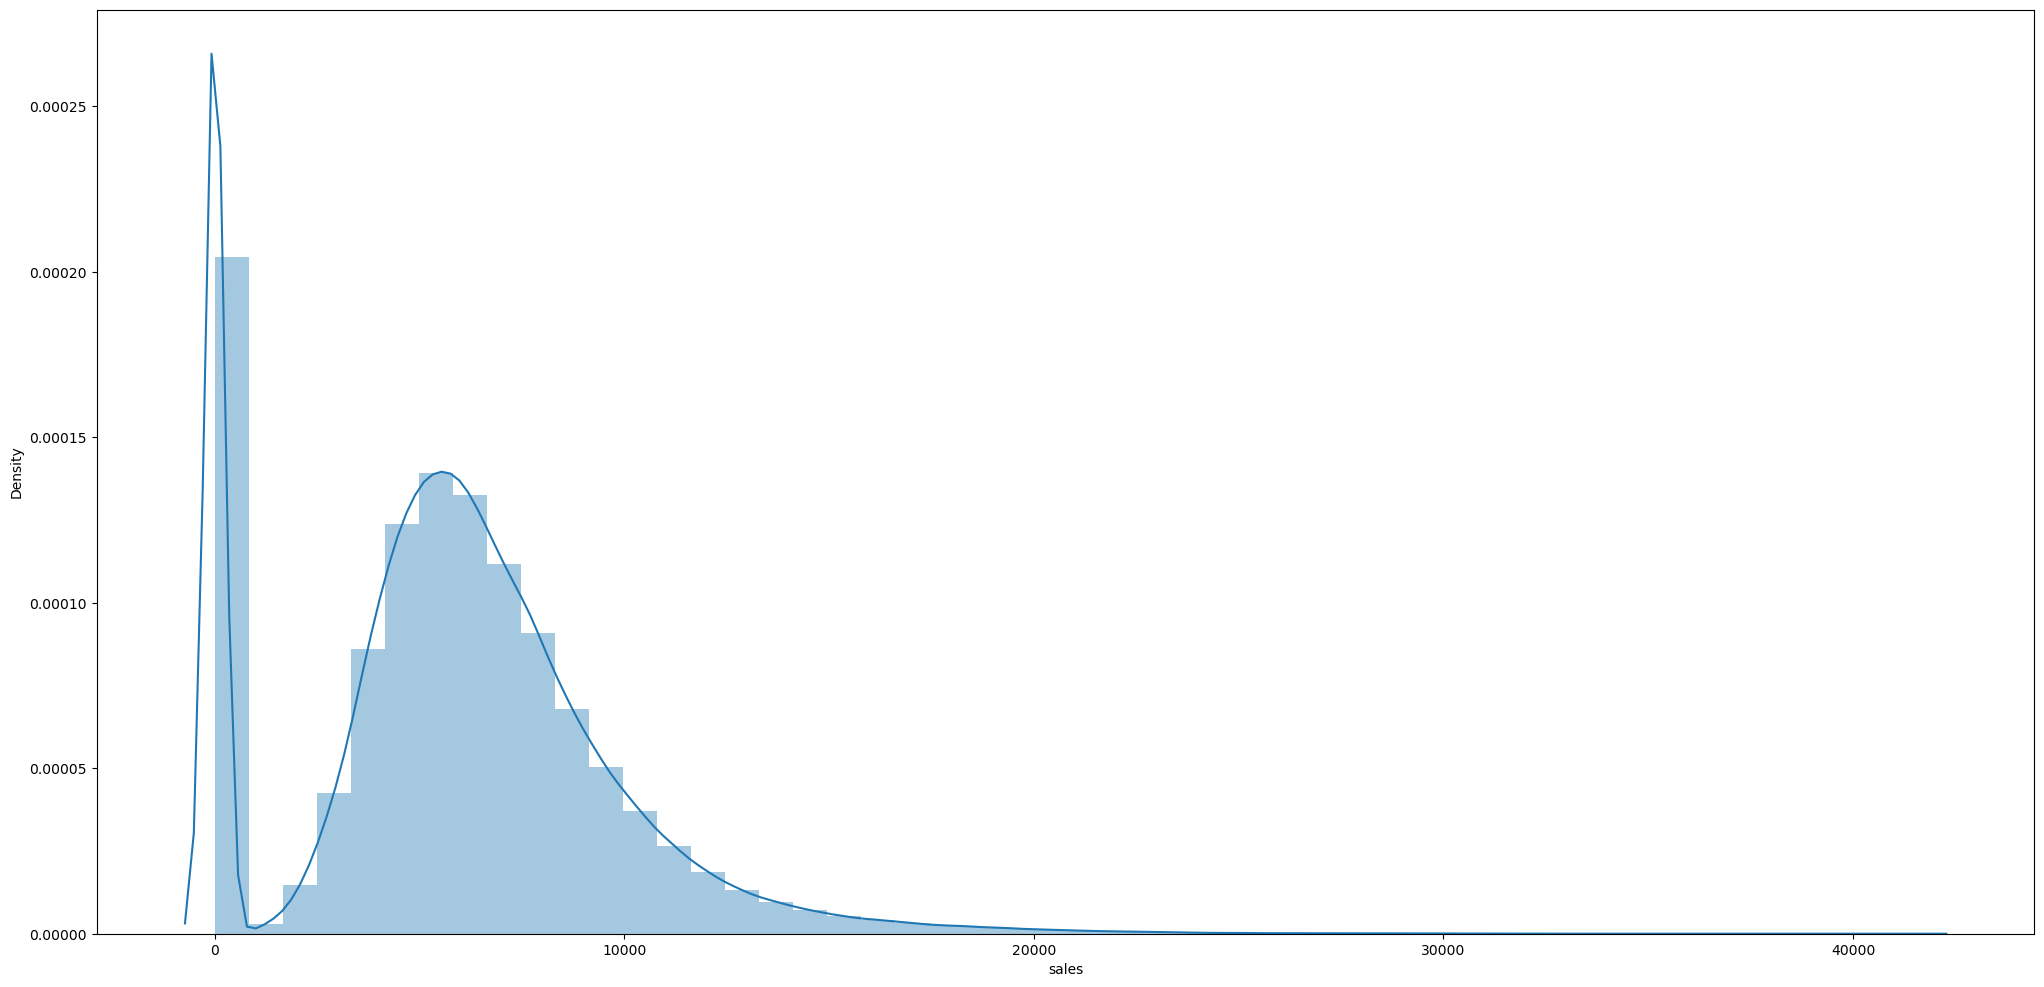

In [18]:
sns.distplot(df1['sales'])

### 1.7.2 Categorical Attributes

In [19]:
# Levels of categorical variables

cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot: xlabel='state_holiday', ylabel='sales'>

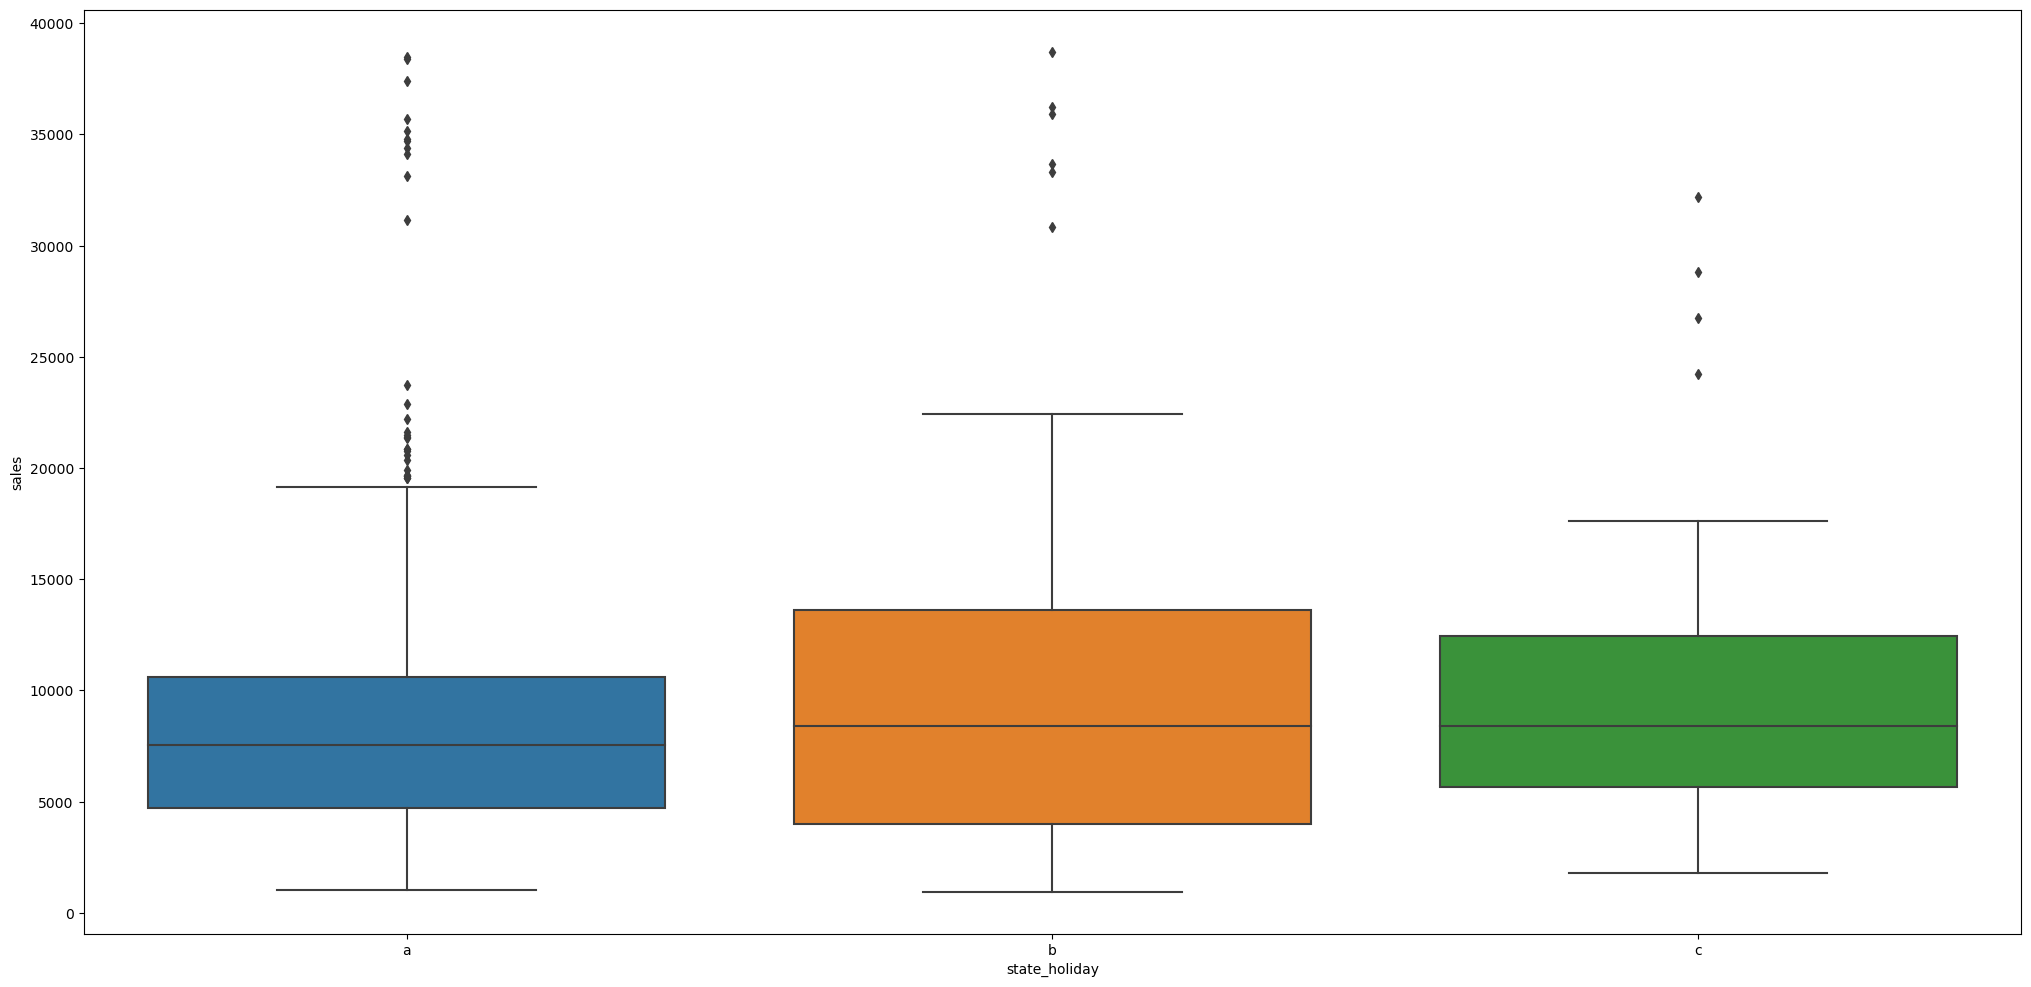

In [20]:
# filtering

aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

sns.boxplot(x='state_holiday', y='sales', data=aux1)

<AxesSubplot: xlabel='assortment', ylabel='sales'>

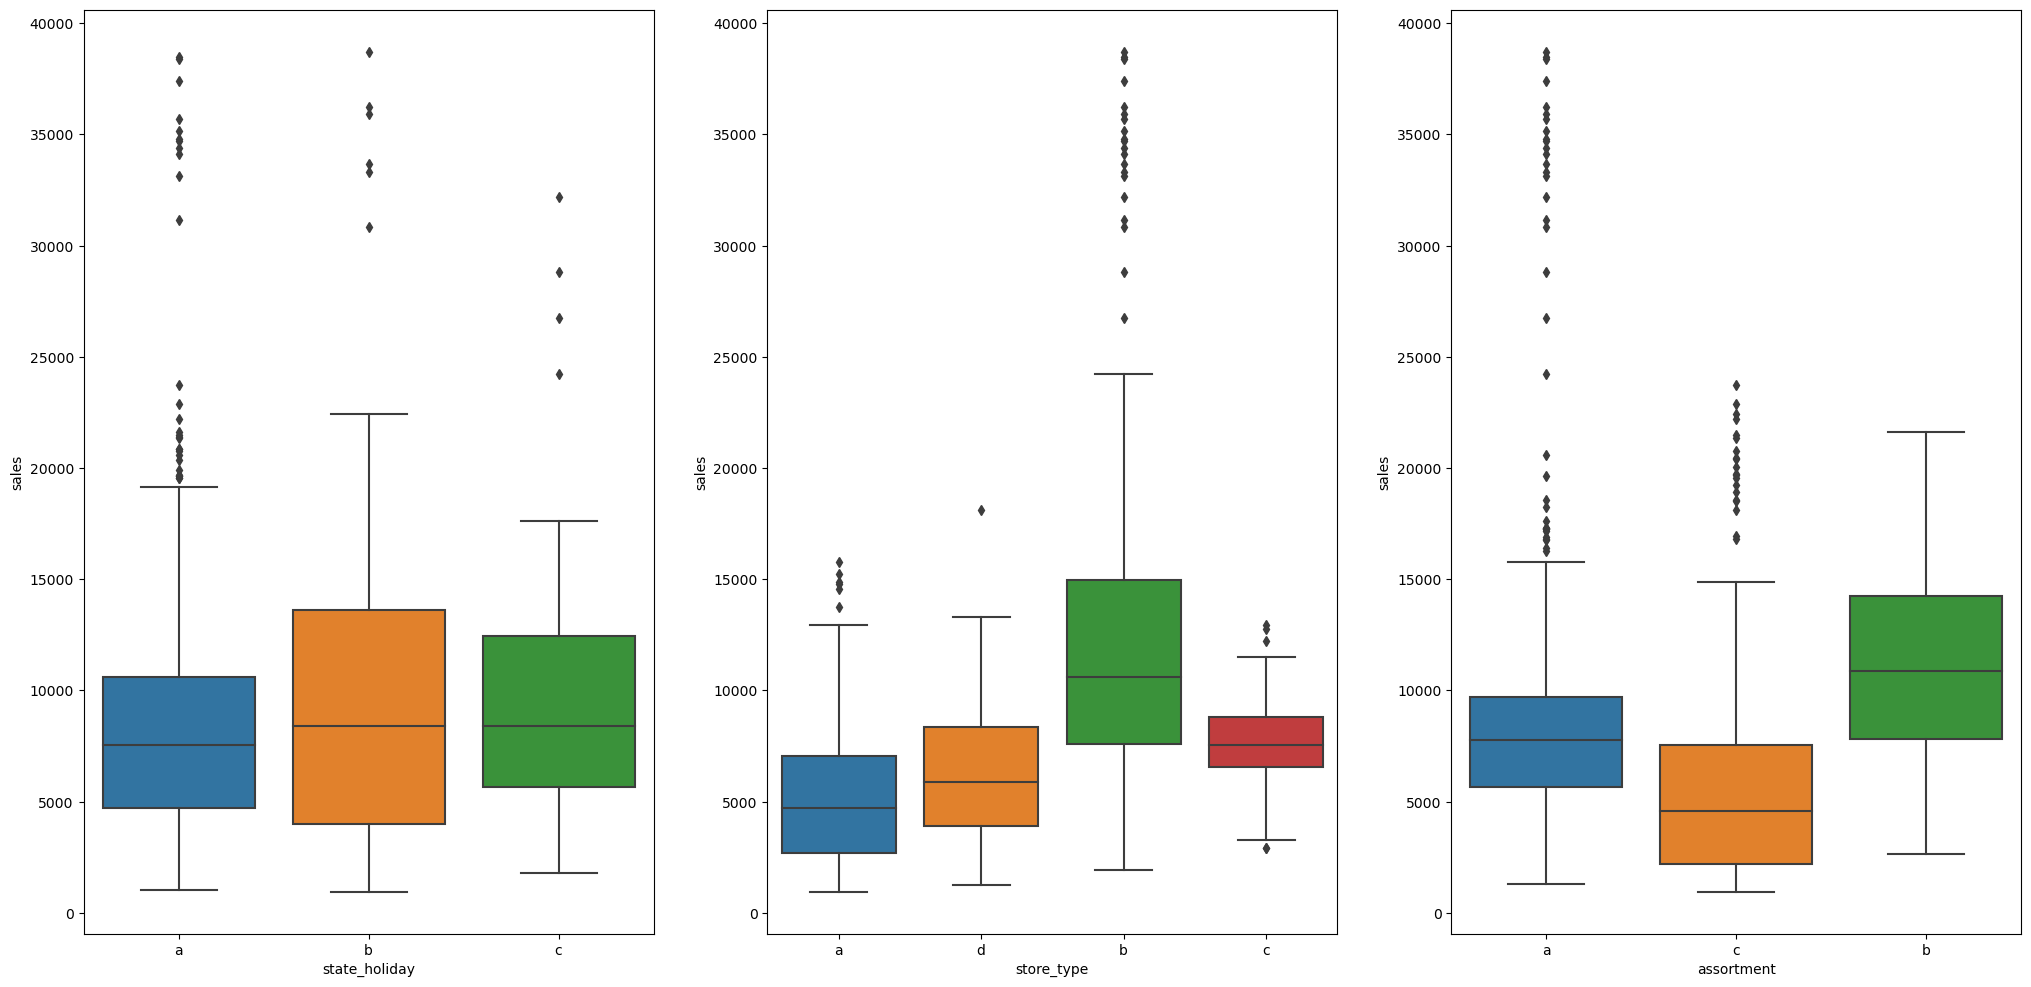

In [21]:
# Analysis of sales distribution in relation to category variables.

aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )
plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )
plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

# 2.0 Feature Engineering - (Step 2)

## 2.1 MindMap Hypotheses

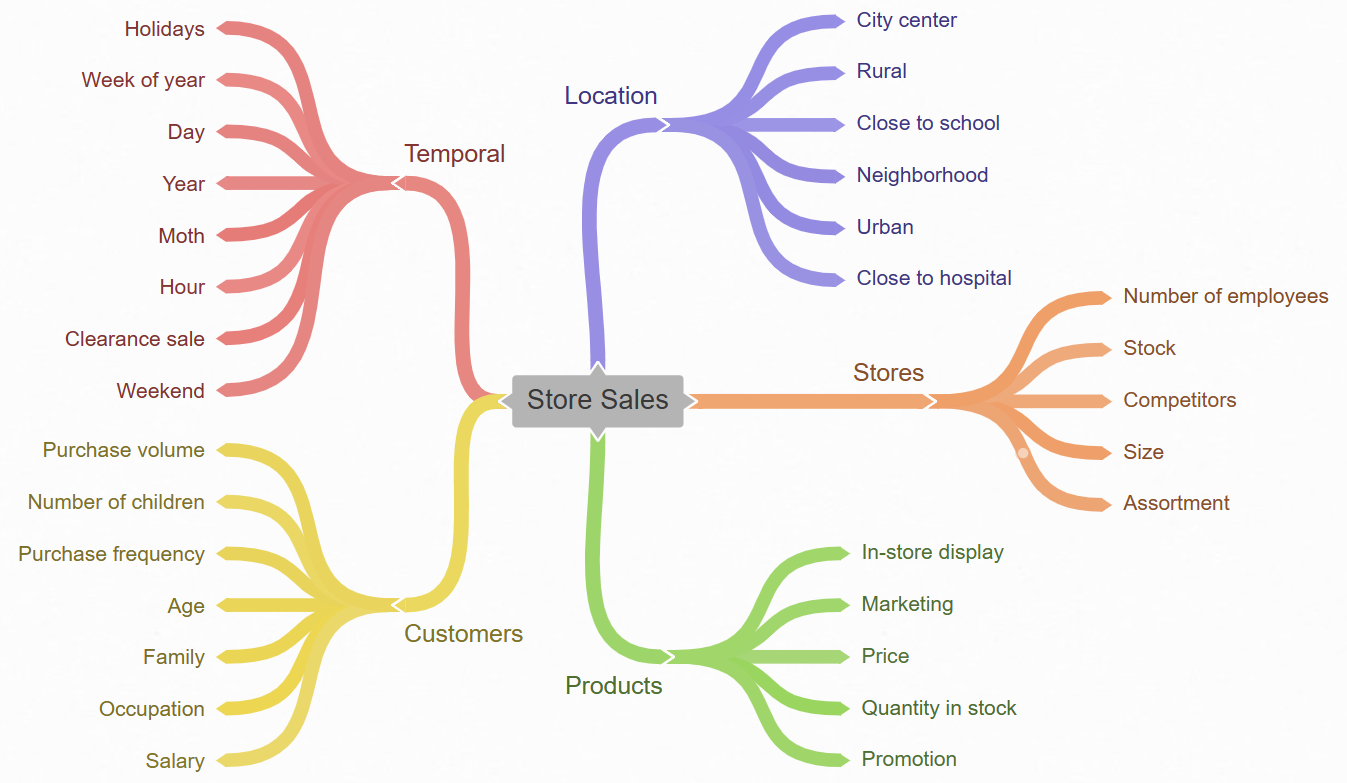

In [22]:
Image('../images/mindmap.PNG')

## 2.2 Hypotheses Creation

In [23]:
df2 = df1.copy()

In [24]:
'''
 I created this mindmap based on my understanding of the drugstore sales phenomenon, combined with the observation of the variables present in 
 the dataset. In a real day-to-day life at a company, this mind map is developed in a brainstorming meeting with the project's stakeholders.
''' 

"\n I created this mindmap based on my understanding of the drugstore sales phenomenon, combined with the observation of the variables present in \n the dataset. In a real day-to-day life at a company, this mind map is developed in a brainstorming meeting with the project's stakeholders.\n"

### 2.2.1 Hipótese Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipótese Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.2.3 Hipótese Tempo.

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [25]:
# Variables derived from the original date variable

#------------------------------------------------------------------------------------------------------------------------------------------------------
# Year 
df2['year'] = df2['date'].dt.year


#------------------------------------------------------------------------------------------------------------------------------------------------------
# Month
df2['month'] = df2['date'].dt.month


#------------------------------------------------------------------------------------------------------------------------------------------------------
# Day
df2['day'] = df2['date'].dt.day


#------------------------------------------------------------------------------------------------------------------------------------------------------
# Week of Year
df2['week_of_year'] = df2['date'].dt.weekofyear


#------------------------------------------------------------------------------------------------------------------------------------------------------
# Year Week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


#------------------------------------------------------------------------------------------------------------------------------------------------------
# Competition Since - pegar a explicaçao do datetime datetime
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


#------------------------------------------------------------------------------------------------------------------------------------------------------
# Promo Since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)


#------------------------------------------------------------------------------------------------------------------------------------------------------
# Assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')


#------------------------------------------------------------------------------------------------------------------------------------------------------
# State Holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x =='c' else 'regular_day')

C:\Users\andre\AppData\Local\Temp\ipykernel_29684\2617535672.py:20: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [26]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Variable Filtering - (Step 3)

In [27]:
df3 = df2.copy()

In [28]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [29]:
# filtering rows and selected columns, avoiding those that contained irrelevant information for the business, in order to make the dataset leaner,
# thinking about performance.

df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [30]:
'''
- I will not use the "customers" column due to business constraints and unavailability for prediction.
- I will remove the "open" column as it lacks variability and any type of information.
- The "promo interval" column will be removed as I have already derived it into the "is promo" column.
- The "month_map" column will be excluded as it is an auxiliary column.
'''

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [31]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Exploratory Data Analysis (Step 4)

In [32]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

C:\Users\andre\AppData\Local\Temp\ipykernel_29684\502745325.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales']);
C:\Users\andre\AppData\Local\Temp\ipykernel_29684\502745325.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log1p(df4['sales']));


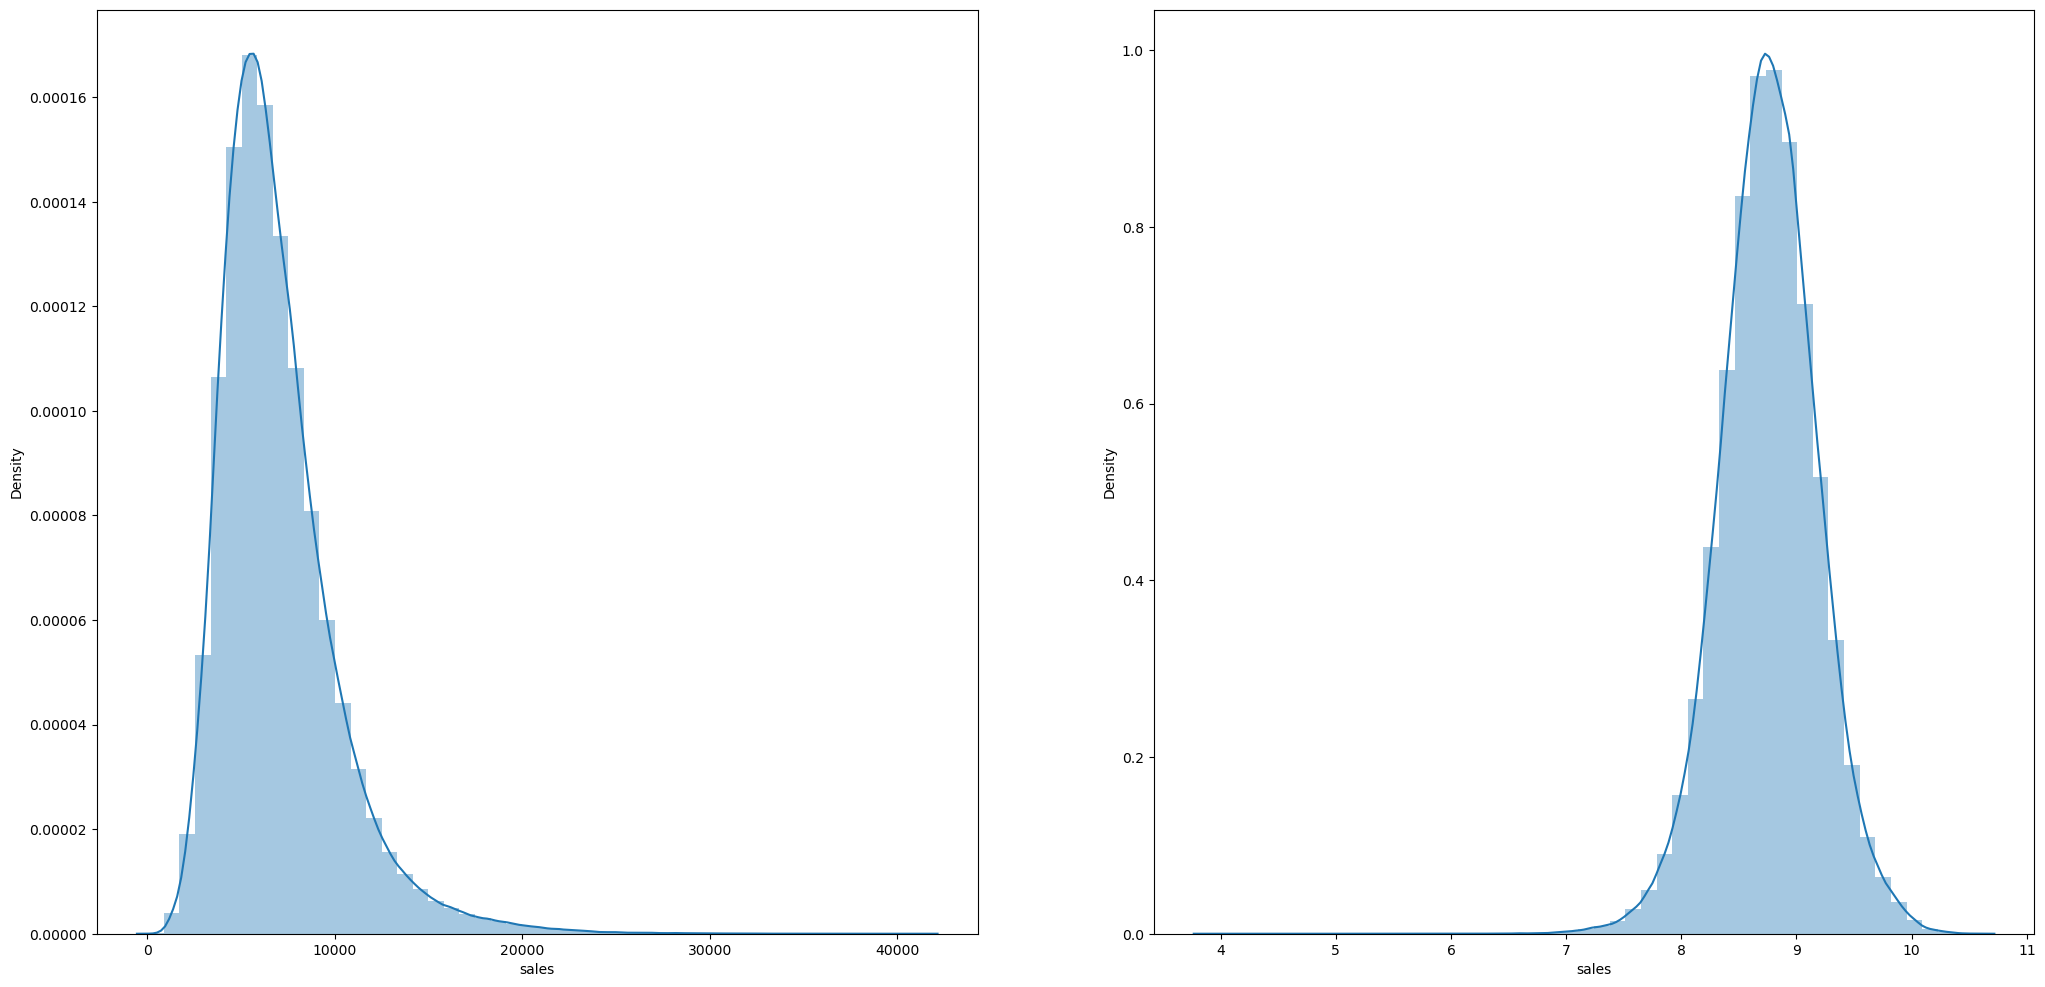

In [33]:
# Univariate analysis response variable 
plt.subplot( 1, 2, 1);
sns.distplot(df4['sales']);


# Transforming response variable closer to normal for machine learning assumption
plt.subplot( 1, 2, 2);
sns.distplot(np.log1p(df4['sales']));

### 4.1.2 Numerical Variable

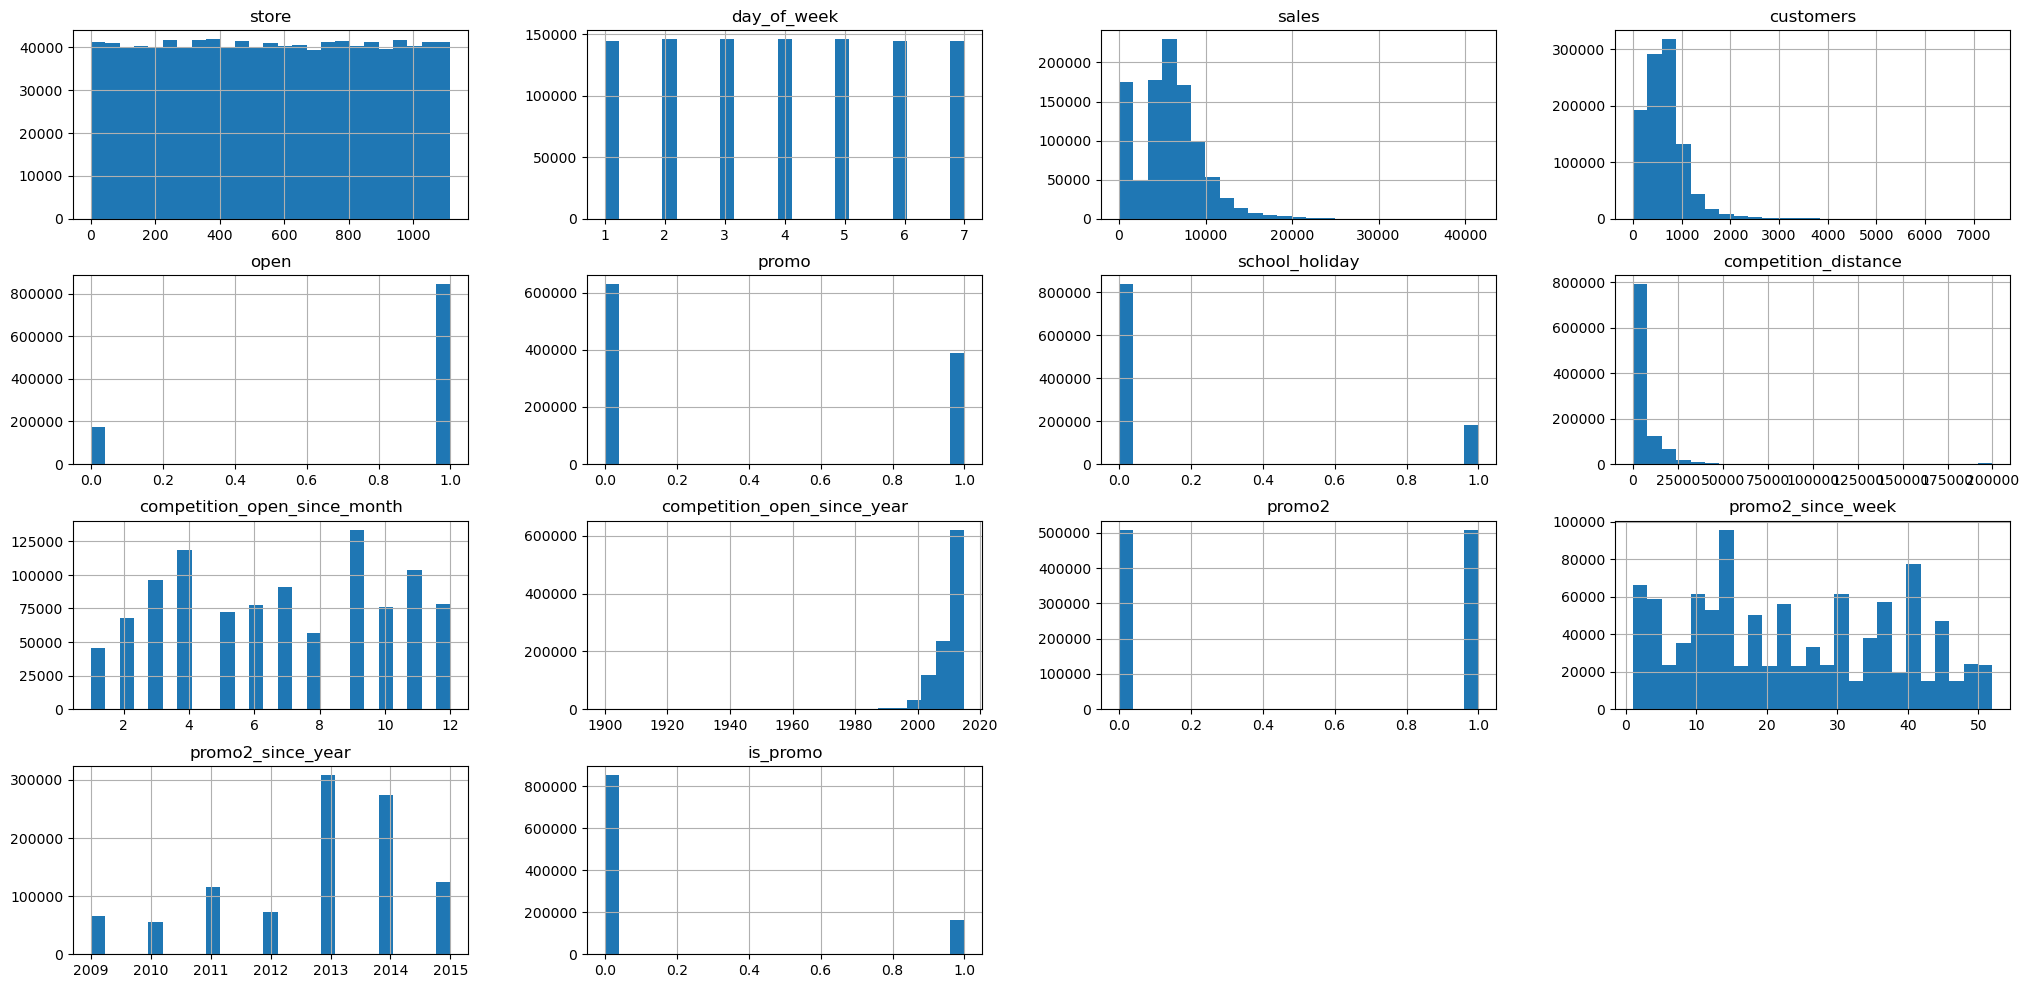

In [34]:
'''
The behavior of a variable determines its ability to explain a phenomenon. 
The more behavior it presents, the greater its explanatory capacity.
'''

num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

In [35]:
# Levels of categorical variables

df4['state_holiday'].drop_duplicates()
df4['store_type'].drop_duplicates()
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot: xlabel='sales', ylabel='Density'>

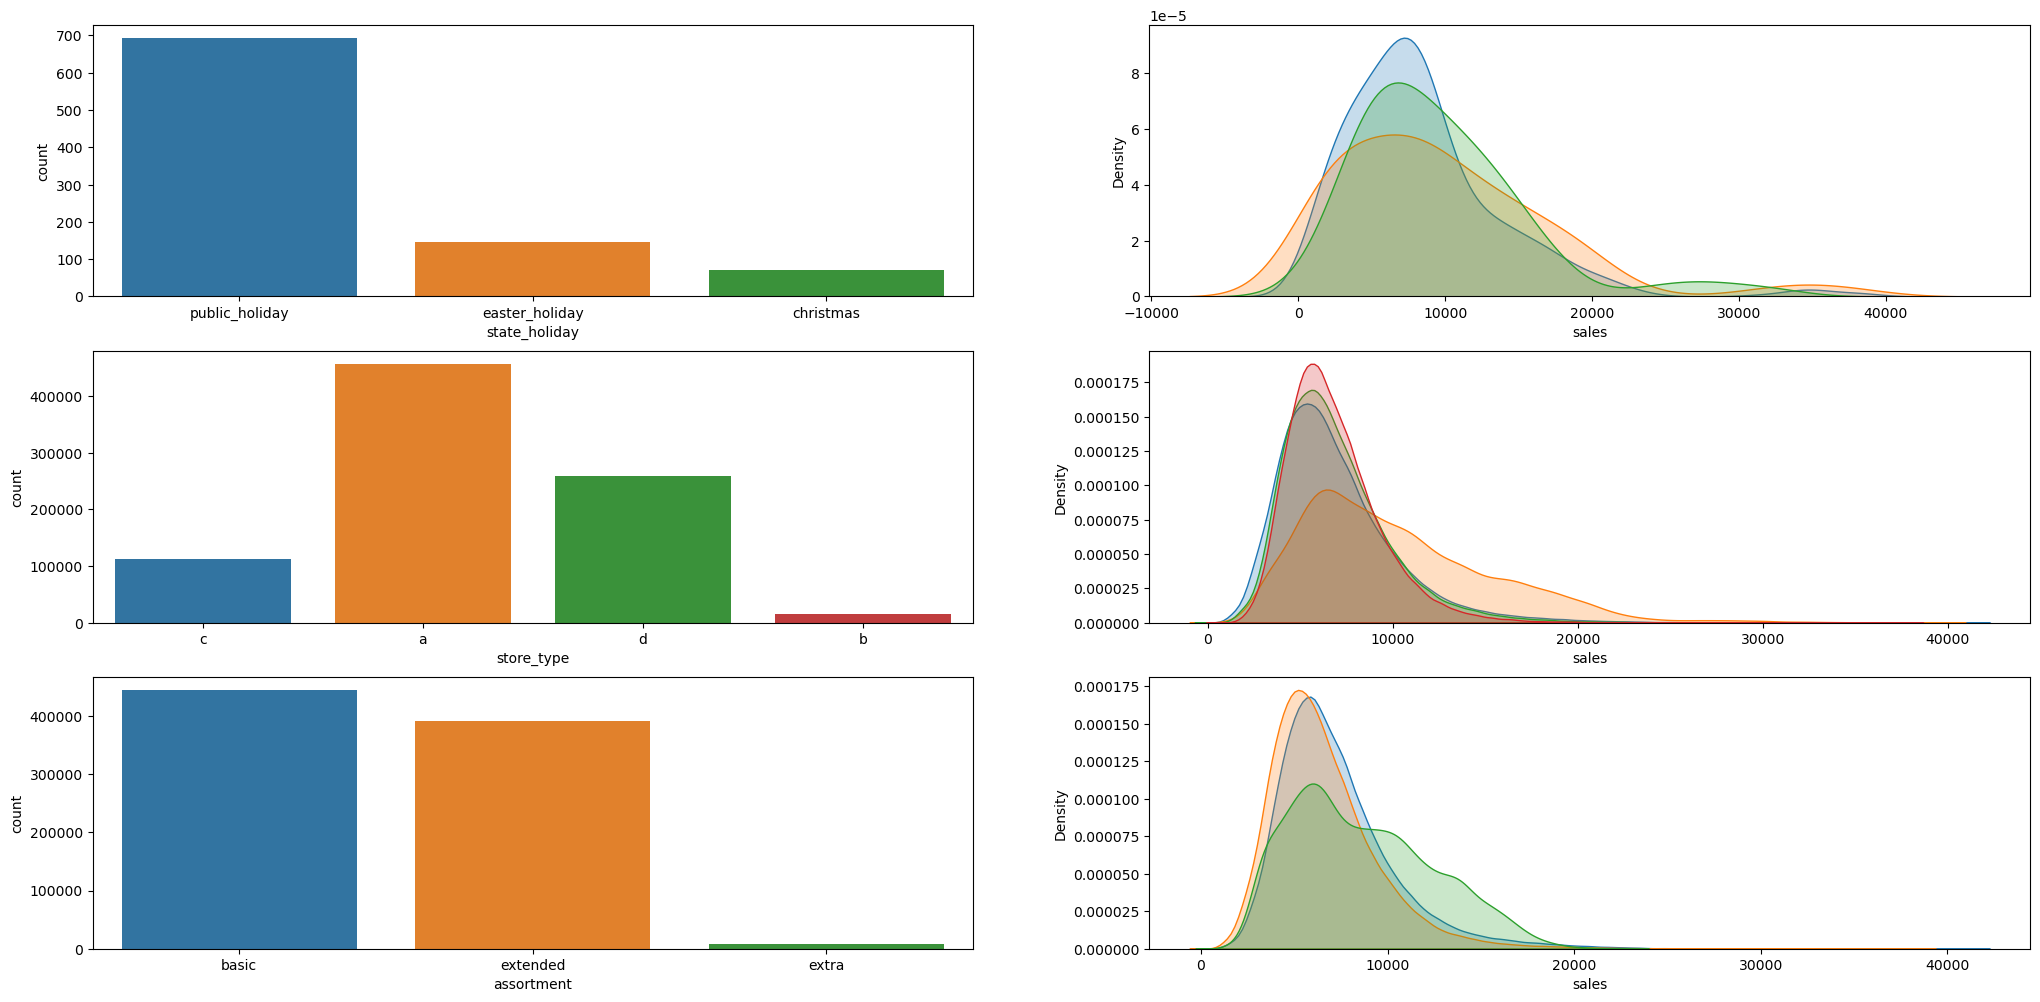

In [36]:
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x = a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', fill = True)

# This variable has information/behavior, interesting for learning the machine learning model


# store_type
plt.subplot(3,2,3)
sns.countplot(x = df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', fill = True)

# This variable has information/behavior, interesting for learning the machine learning model


# Assortment
plt.subplot(3,2,5)
sns.countplot(x = df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', fill = True)

# This variable has information/behavior, interesting for learning the machine learning model

## 4.2 Análise Bivariada

### **H1. Lojas com maior sortimentos deveriam vender mais.**
**FALSA** - Lojas com maior sortimento VENDEM MENOS!

<AxesSubplot: xlabel='year_week'>

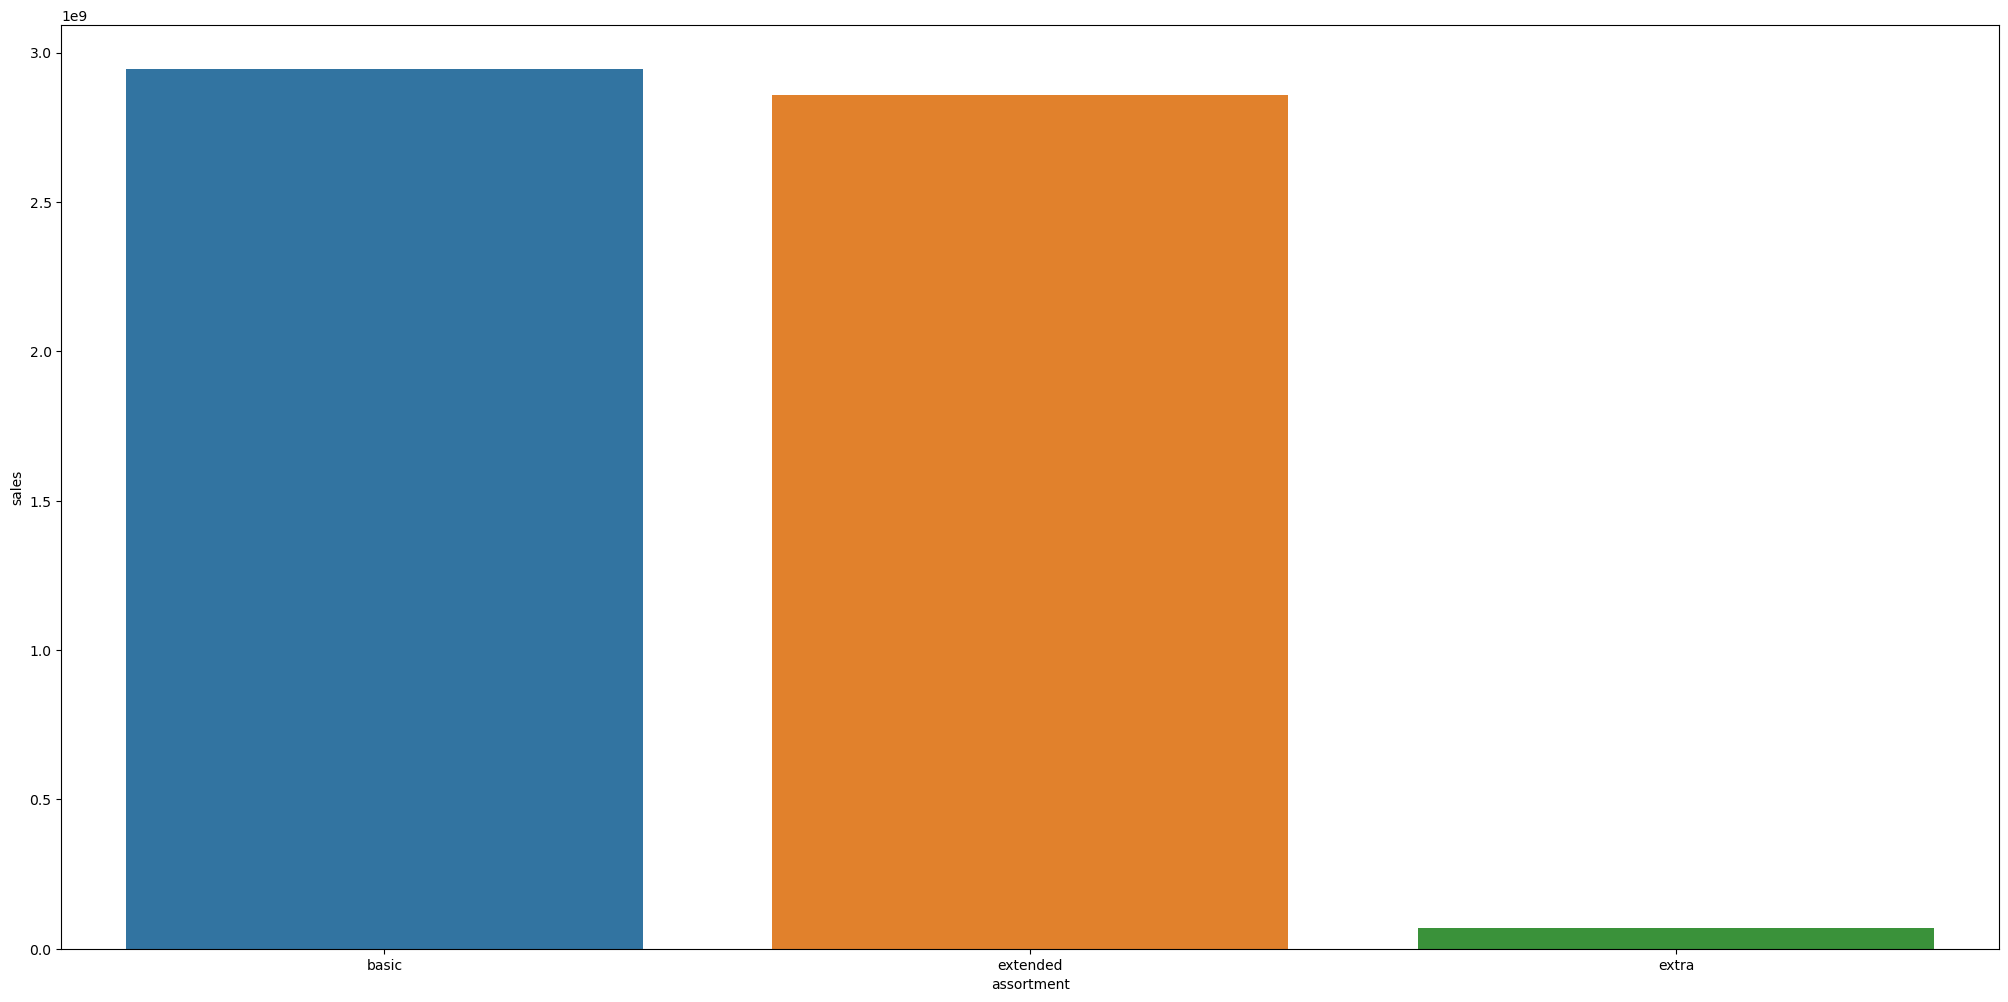

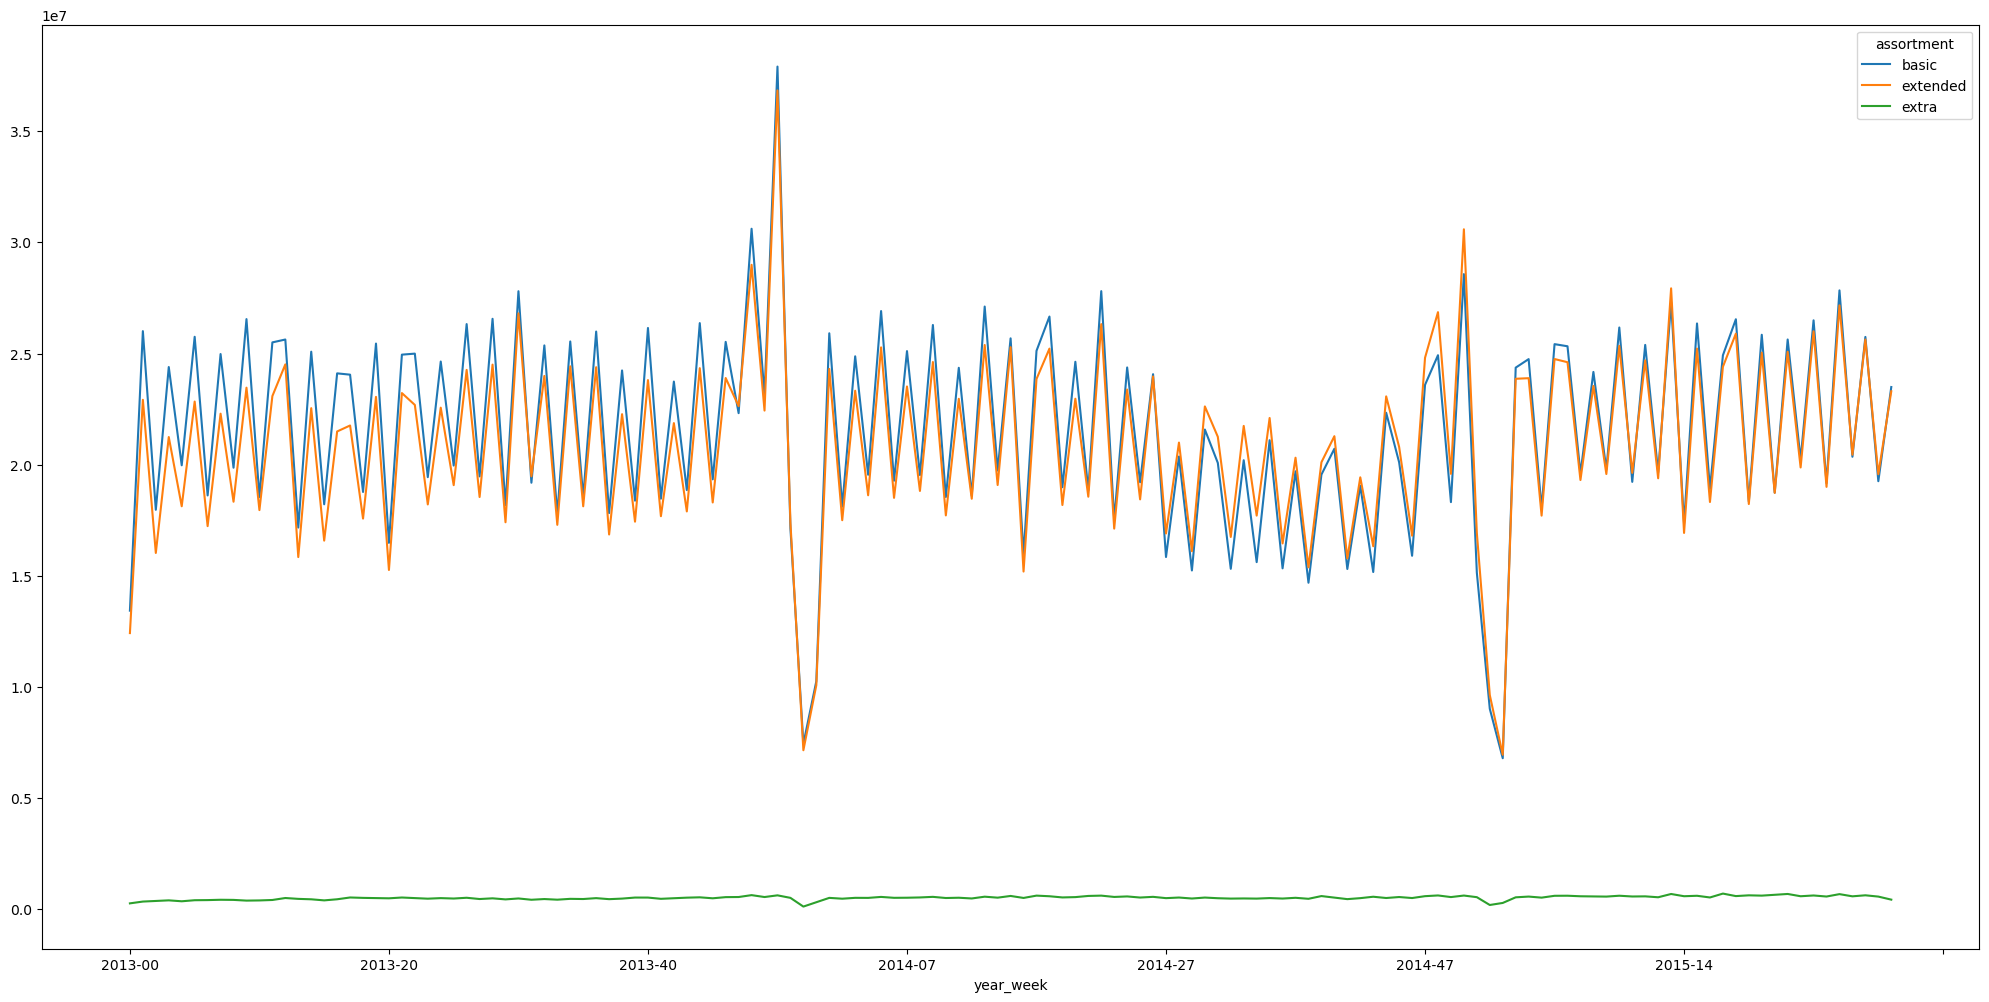

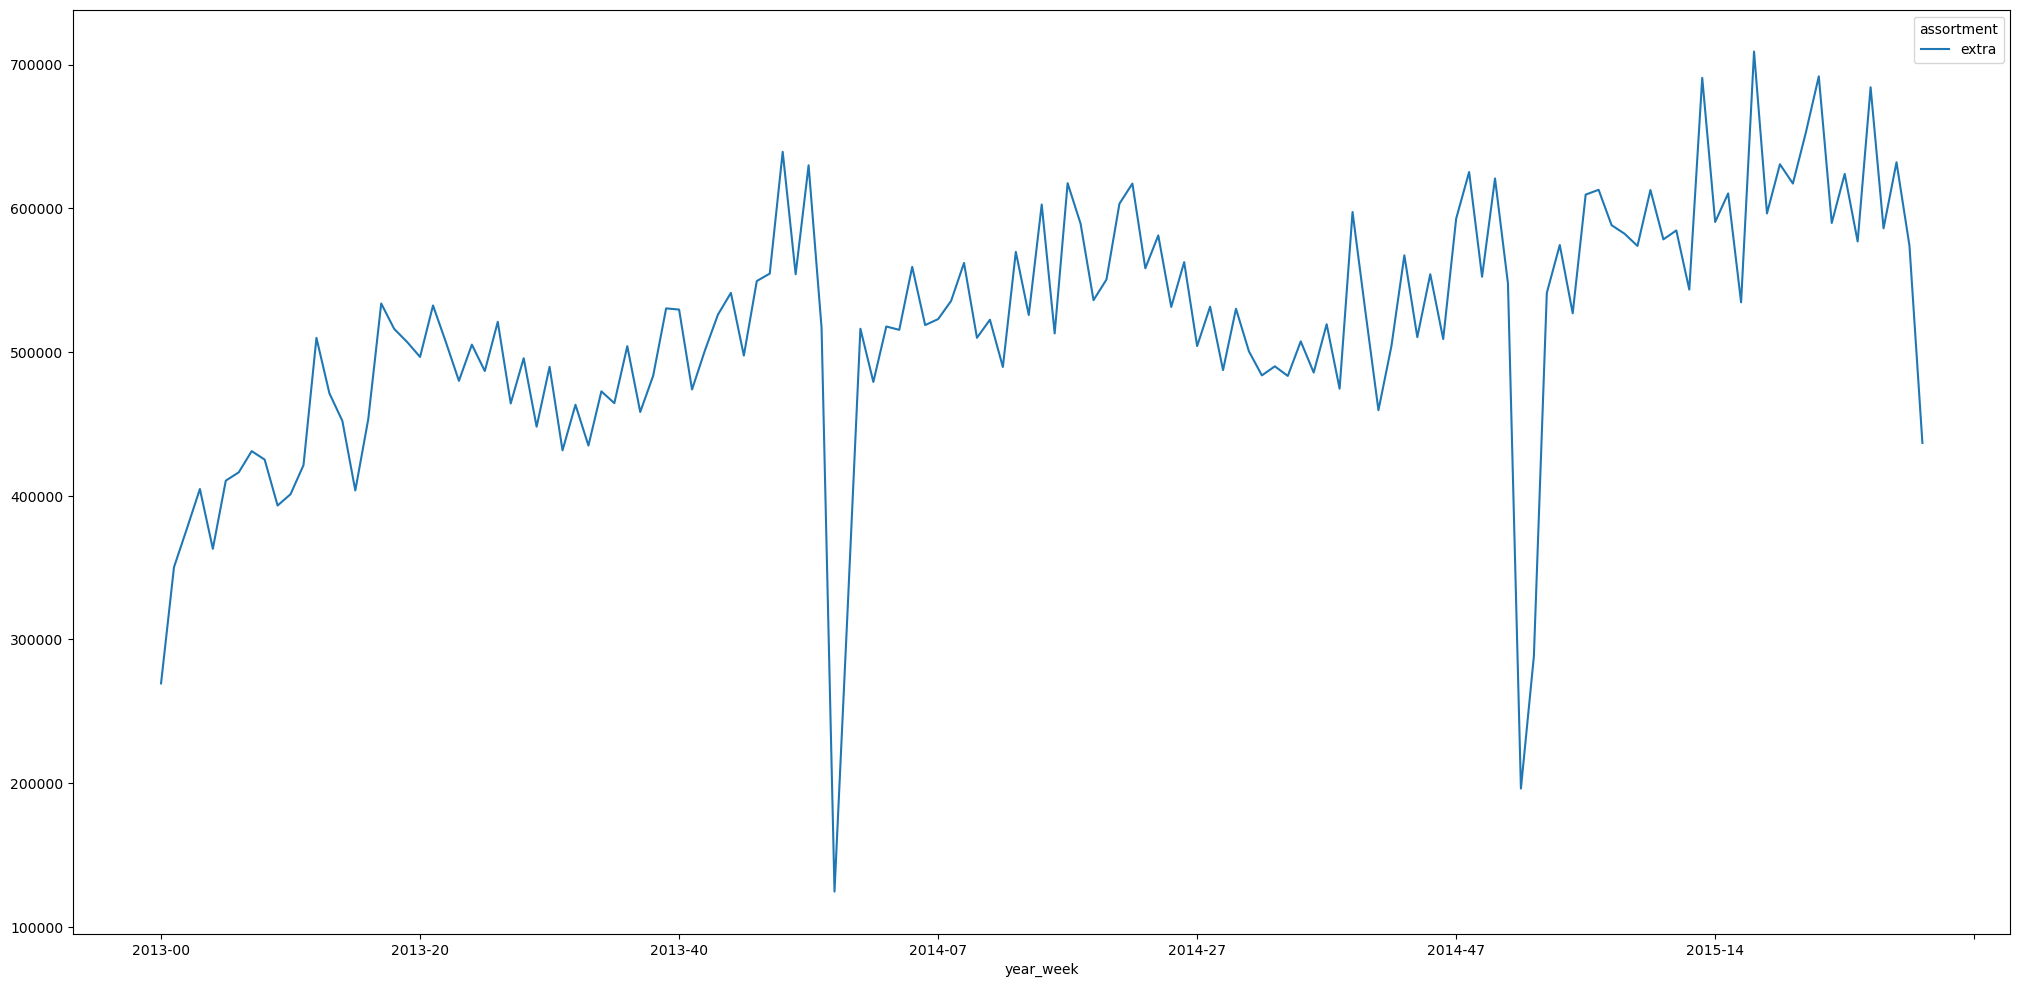

In [37]:
# Assortment plot
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);


# Variation over time of assortment types
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()


# To check the "extra" plot
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()


# Two points about our H1, in terms of: hypothesis validation(1), relevance to the model(2):
# 1- Stores with greater assortment SELL LESS!
# 2- Yes it is relevant to the model.

### **H2. Lojas com competidores mais próximos deveriam vender menos.**
**FALSA** - Lojas com competidores mais próximos VENDEM MAIS!

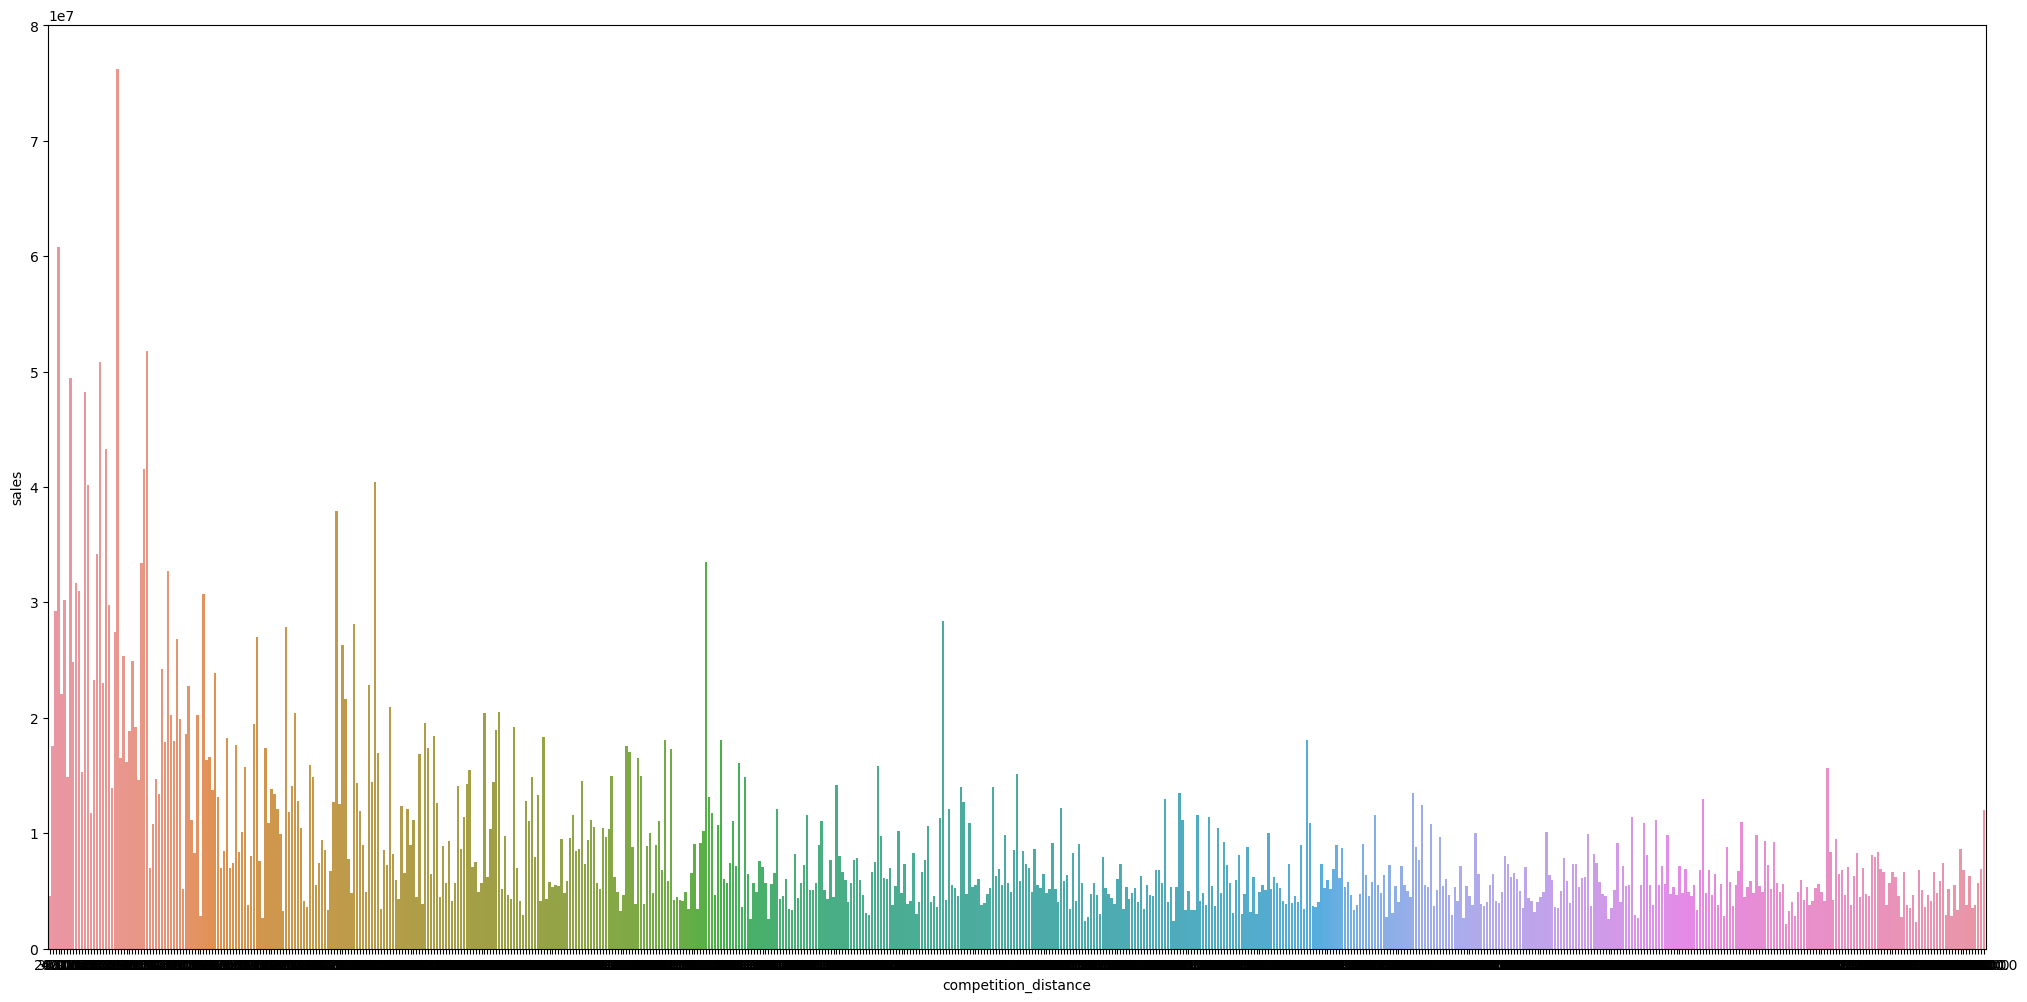

In [38]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.barplot(x='competition_distance', y='sales', data=aux1);

# Very granular graph - create groupings (bins) for easy visualization

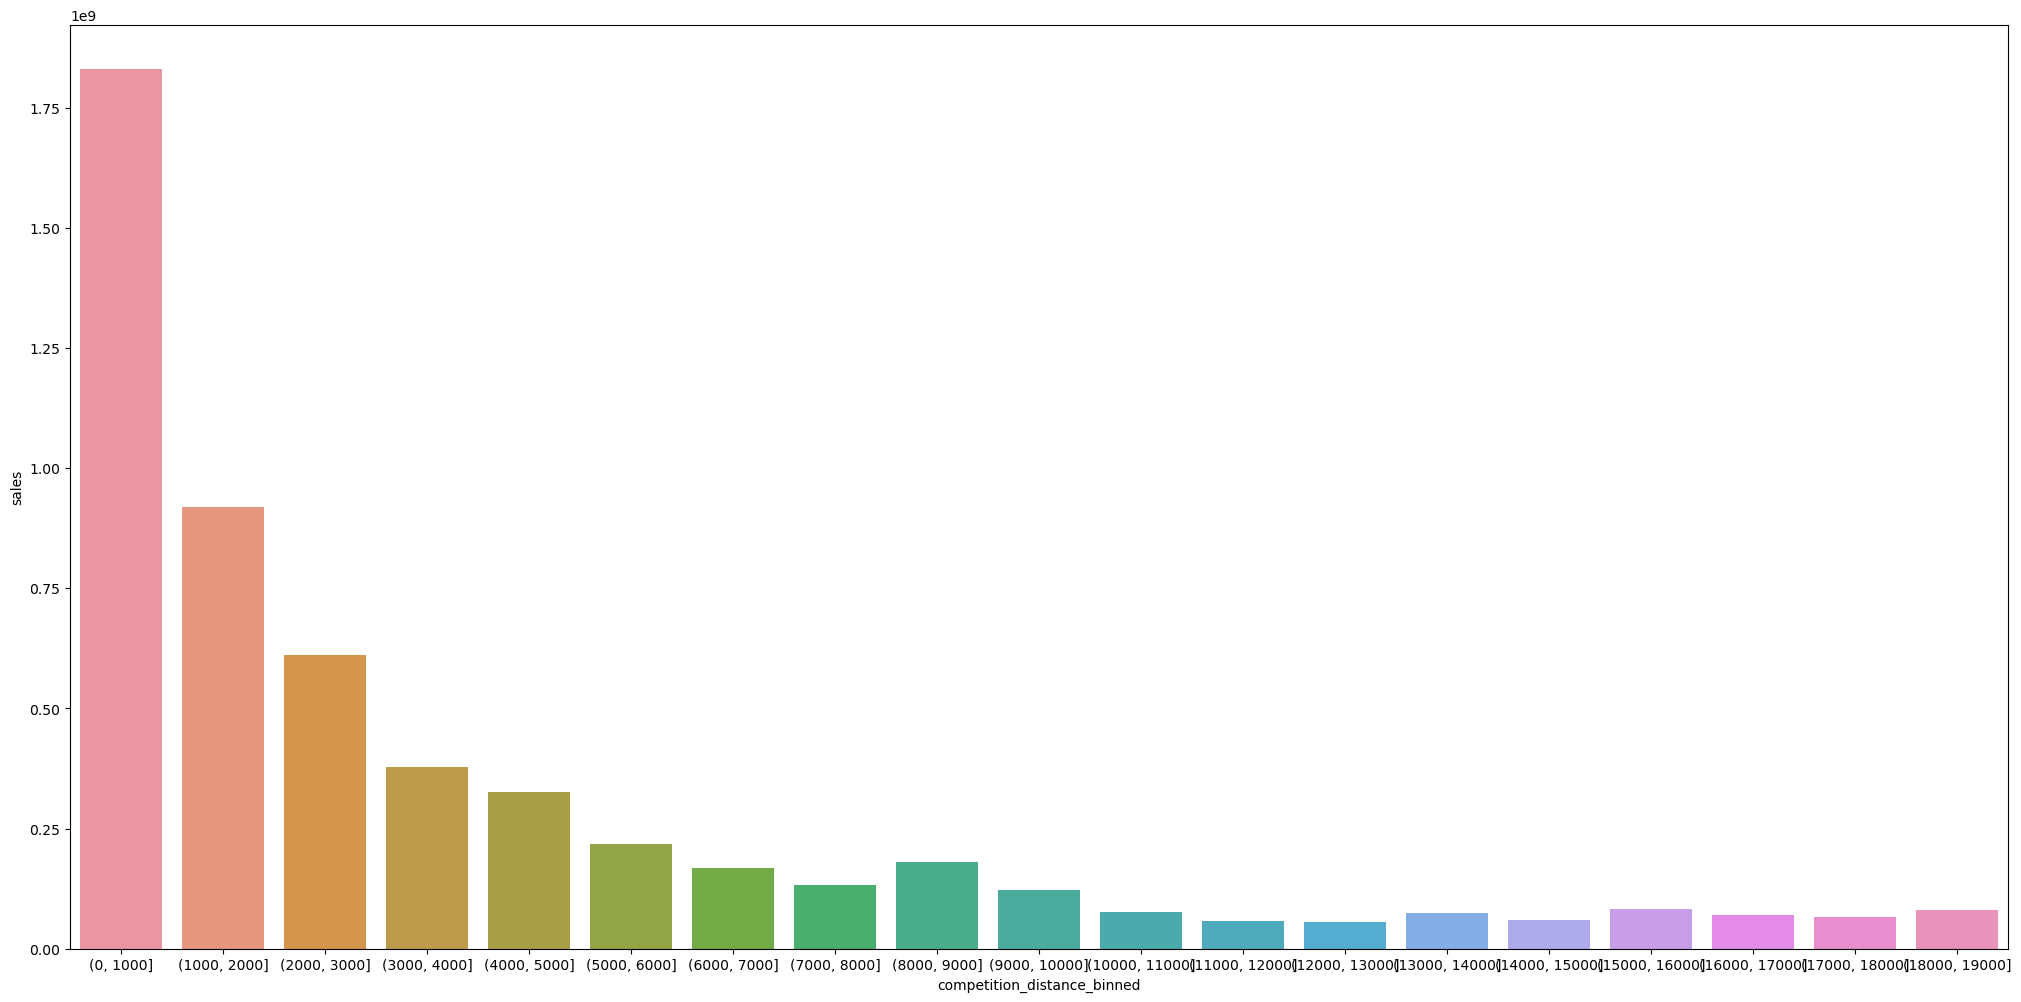

In [39]:
# Adjusting in bins
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)


# Then add up all sales within the groups
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);

<AxesSubplot: xlabel='competition_distance', ylabel='sales'>

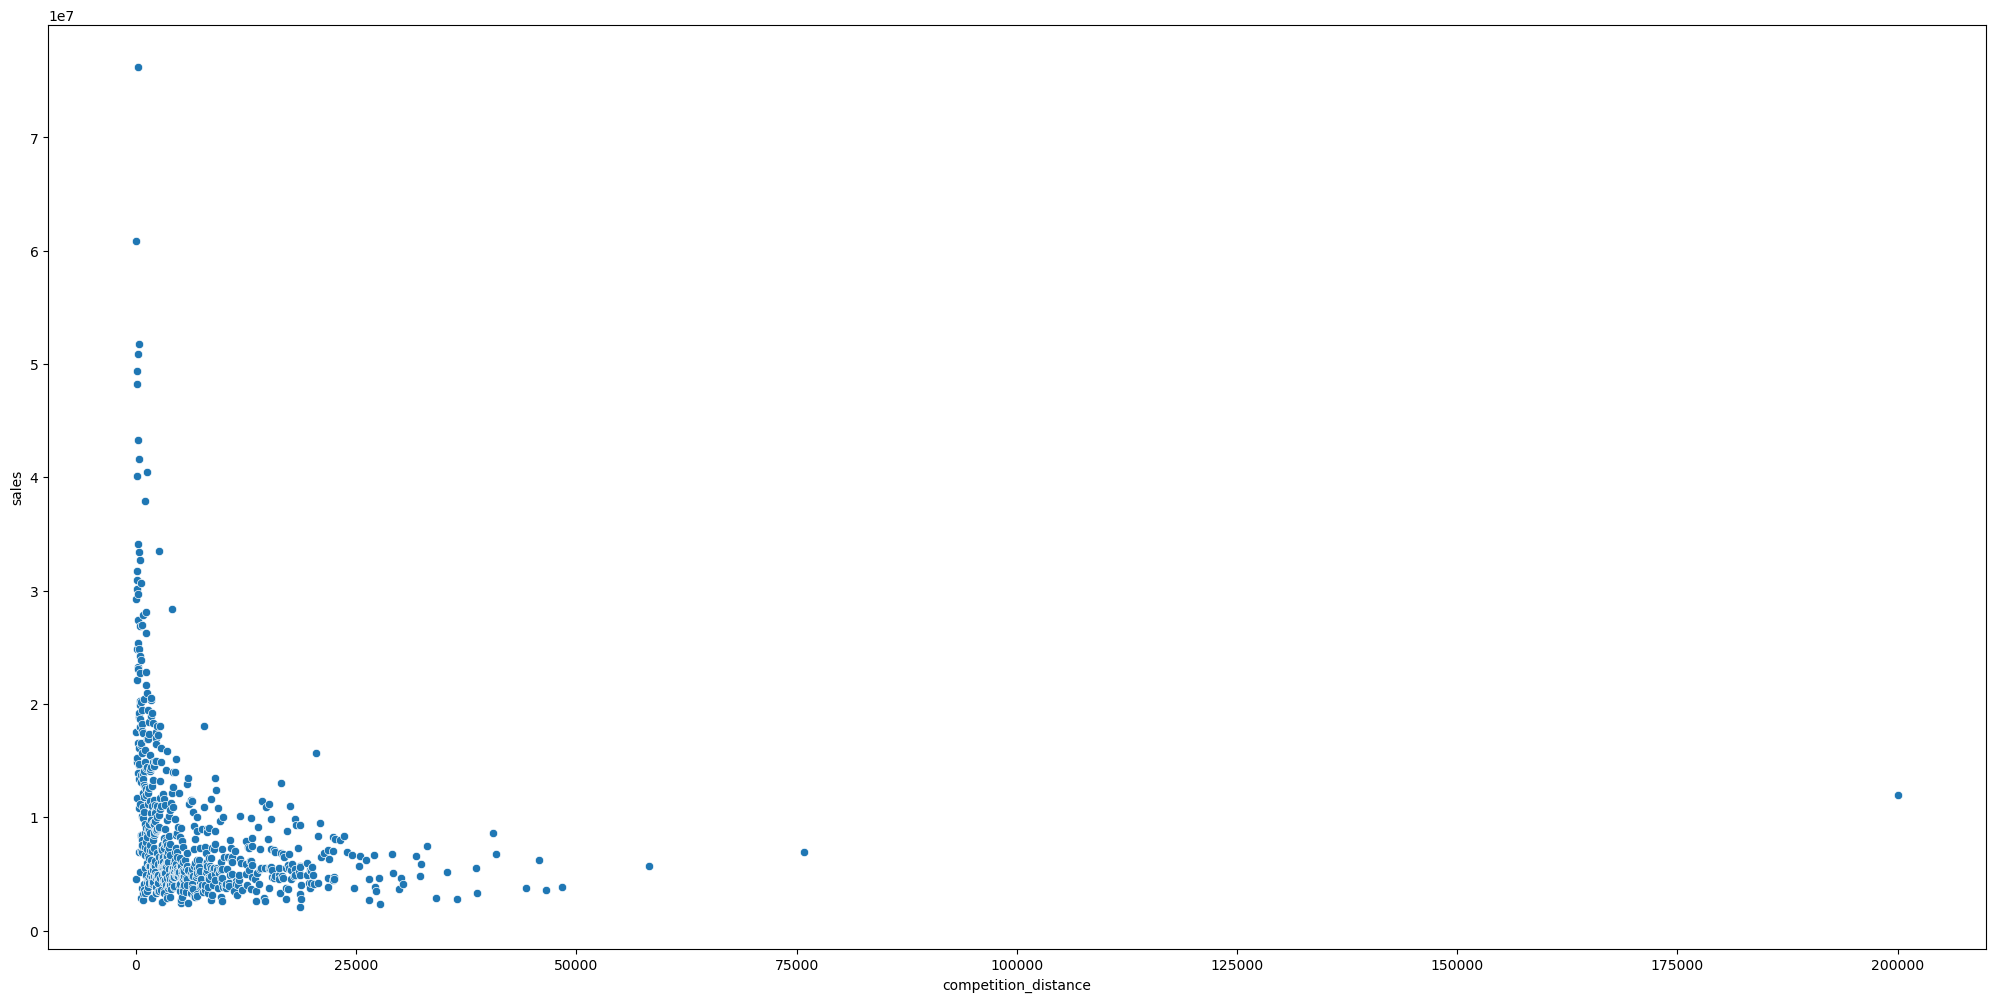

In [40]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1)

<AxesSubplot: >

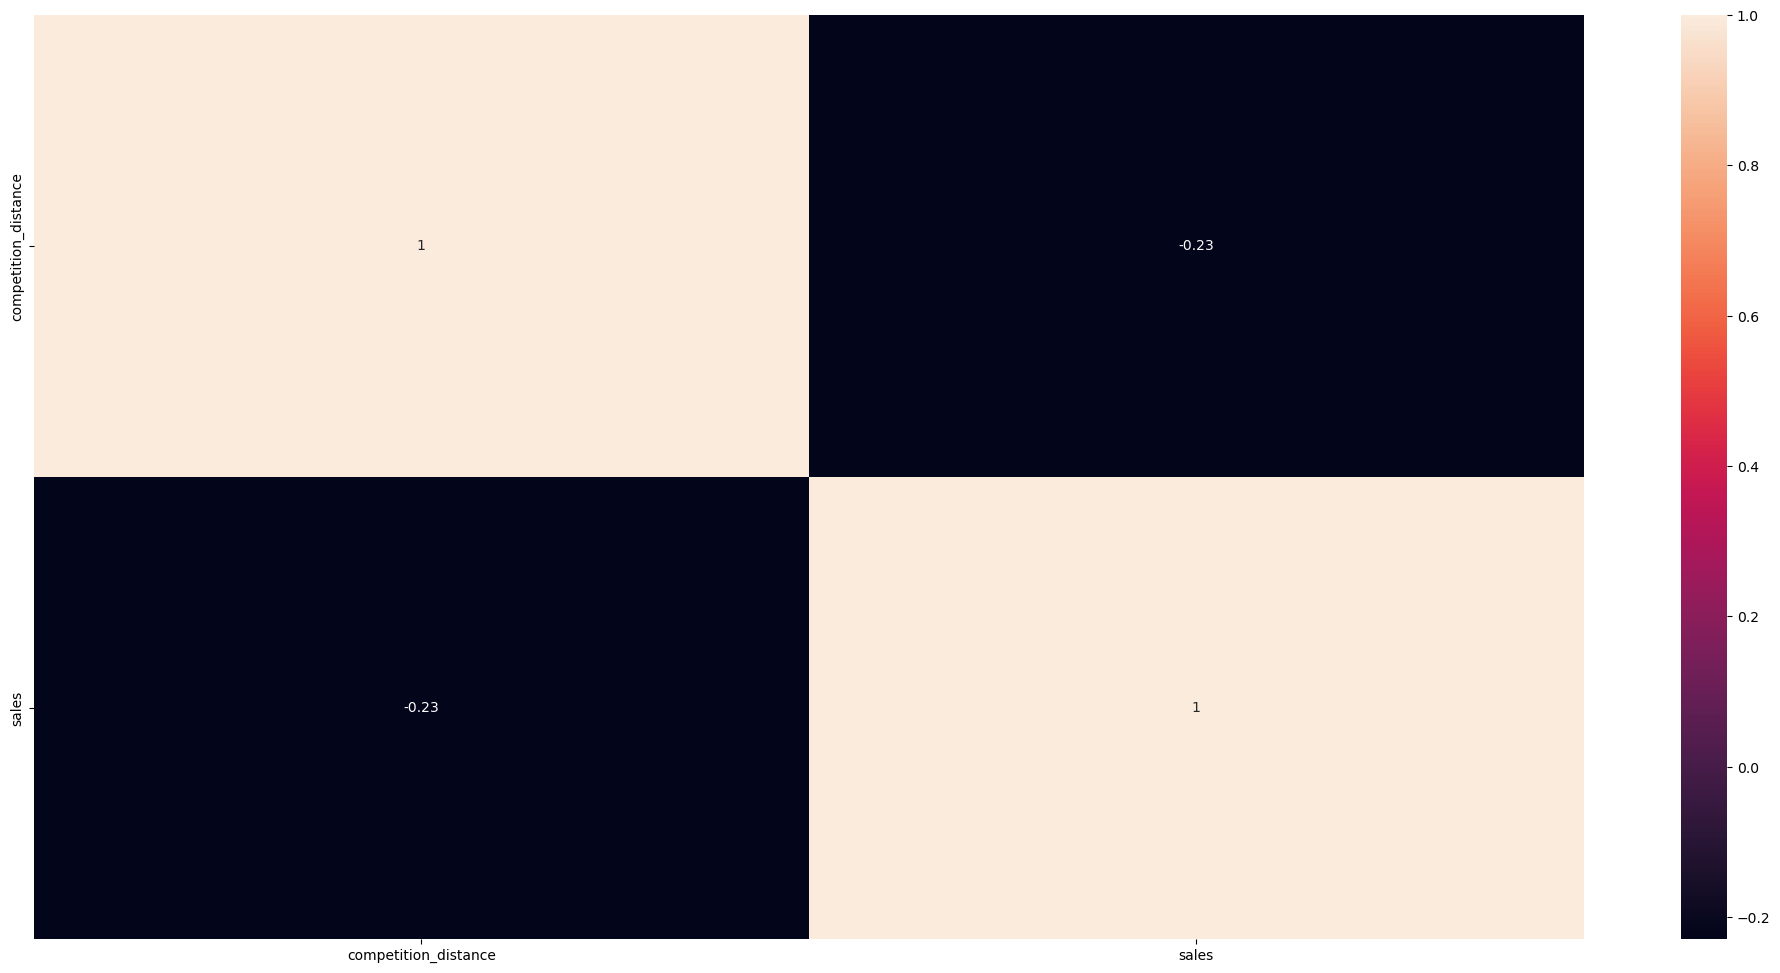

In [41]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.heatmap(aux1.corr(method='pearson'), annot = True)

C:\Users\andre\AppData\Local\Temp\ipykernel_29684\3442330909.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(method='pearson'), annot = True);


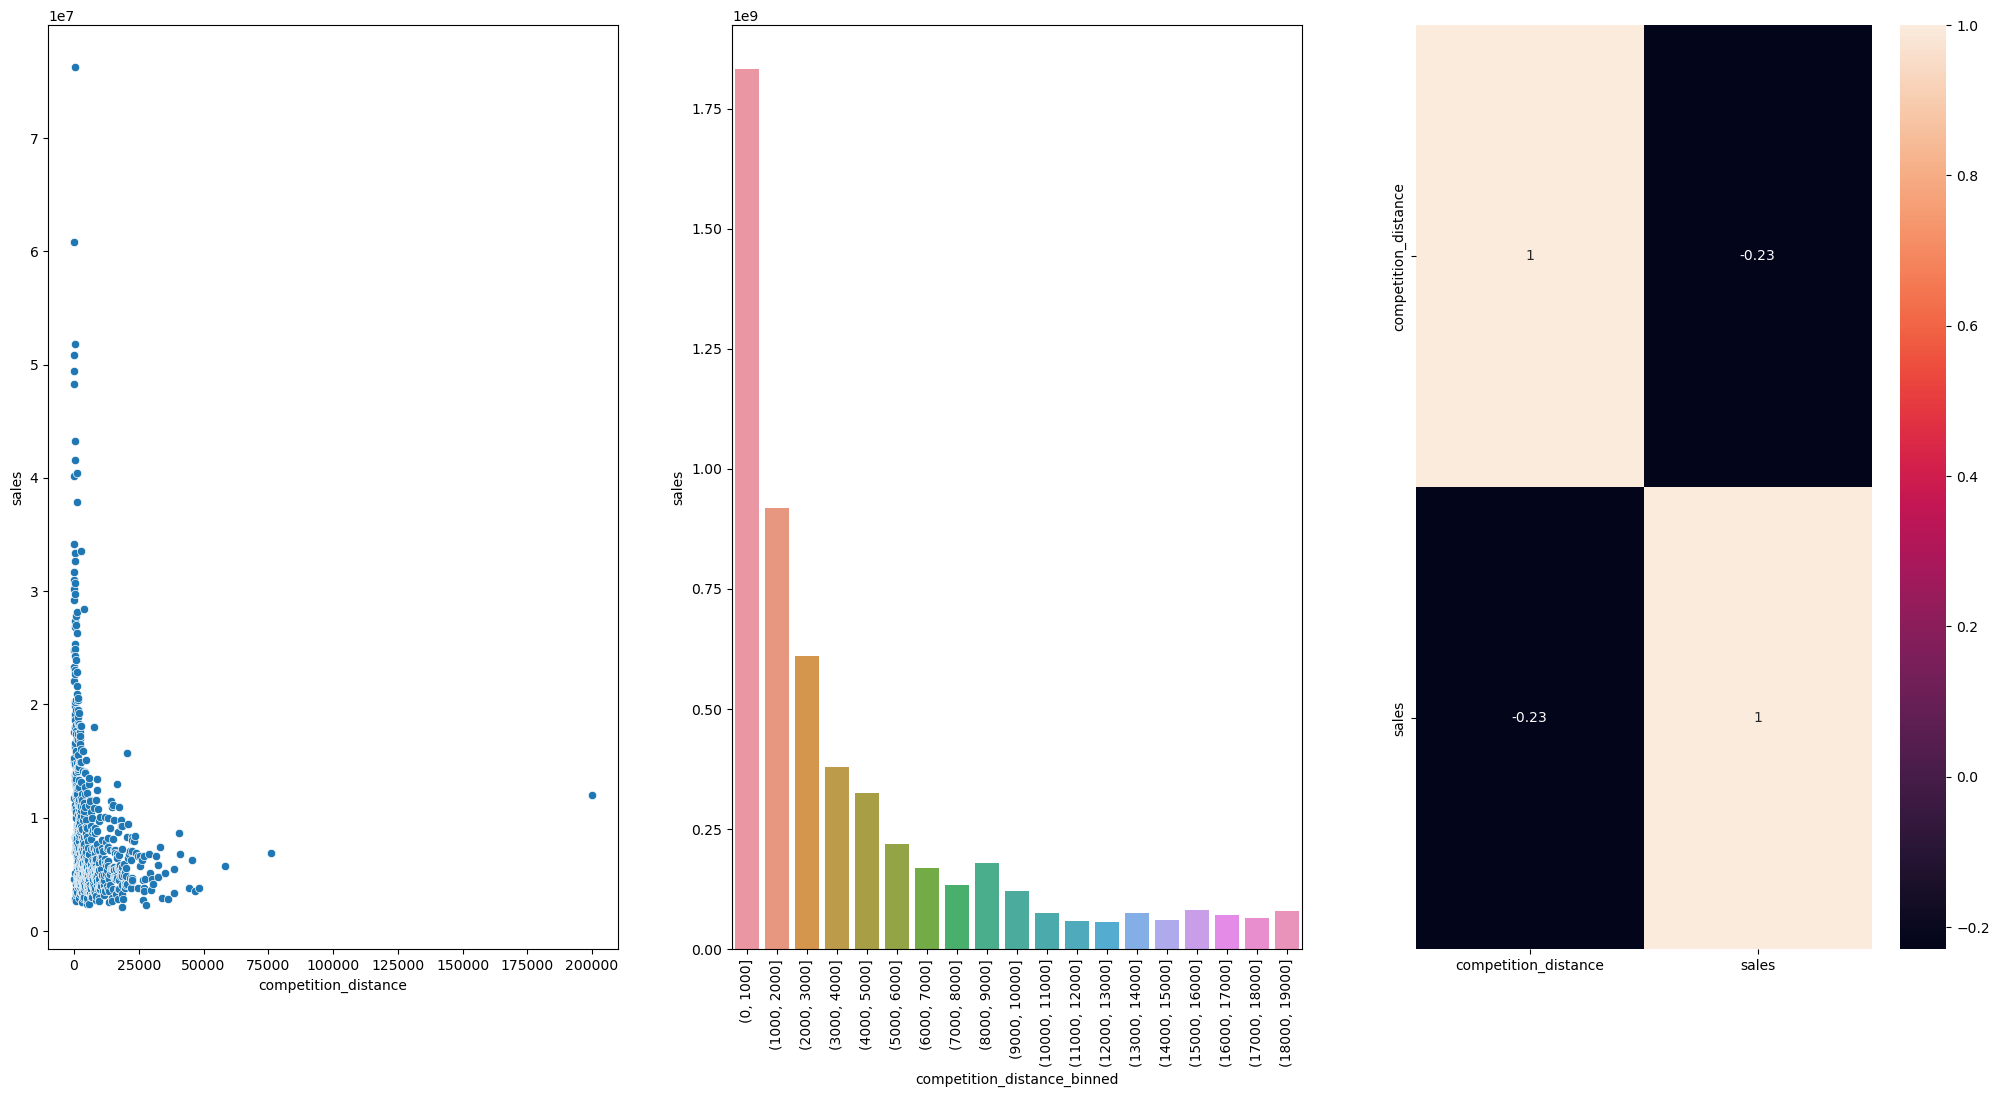

In [42]:
# Summary
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);


# Close competitors, encourage much more sales competition. (Insight that shocks a belief!)
# A correlation of -0.23 can be interesting for the model.

### **H3. Lojas com competidores à mais tempo deveriam vender mais.**
**FALSA** - Lojas com competidores a MAIS TEMPO vendem MENOS!

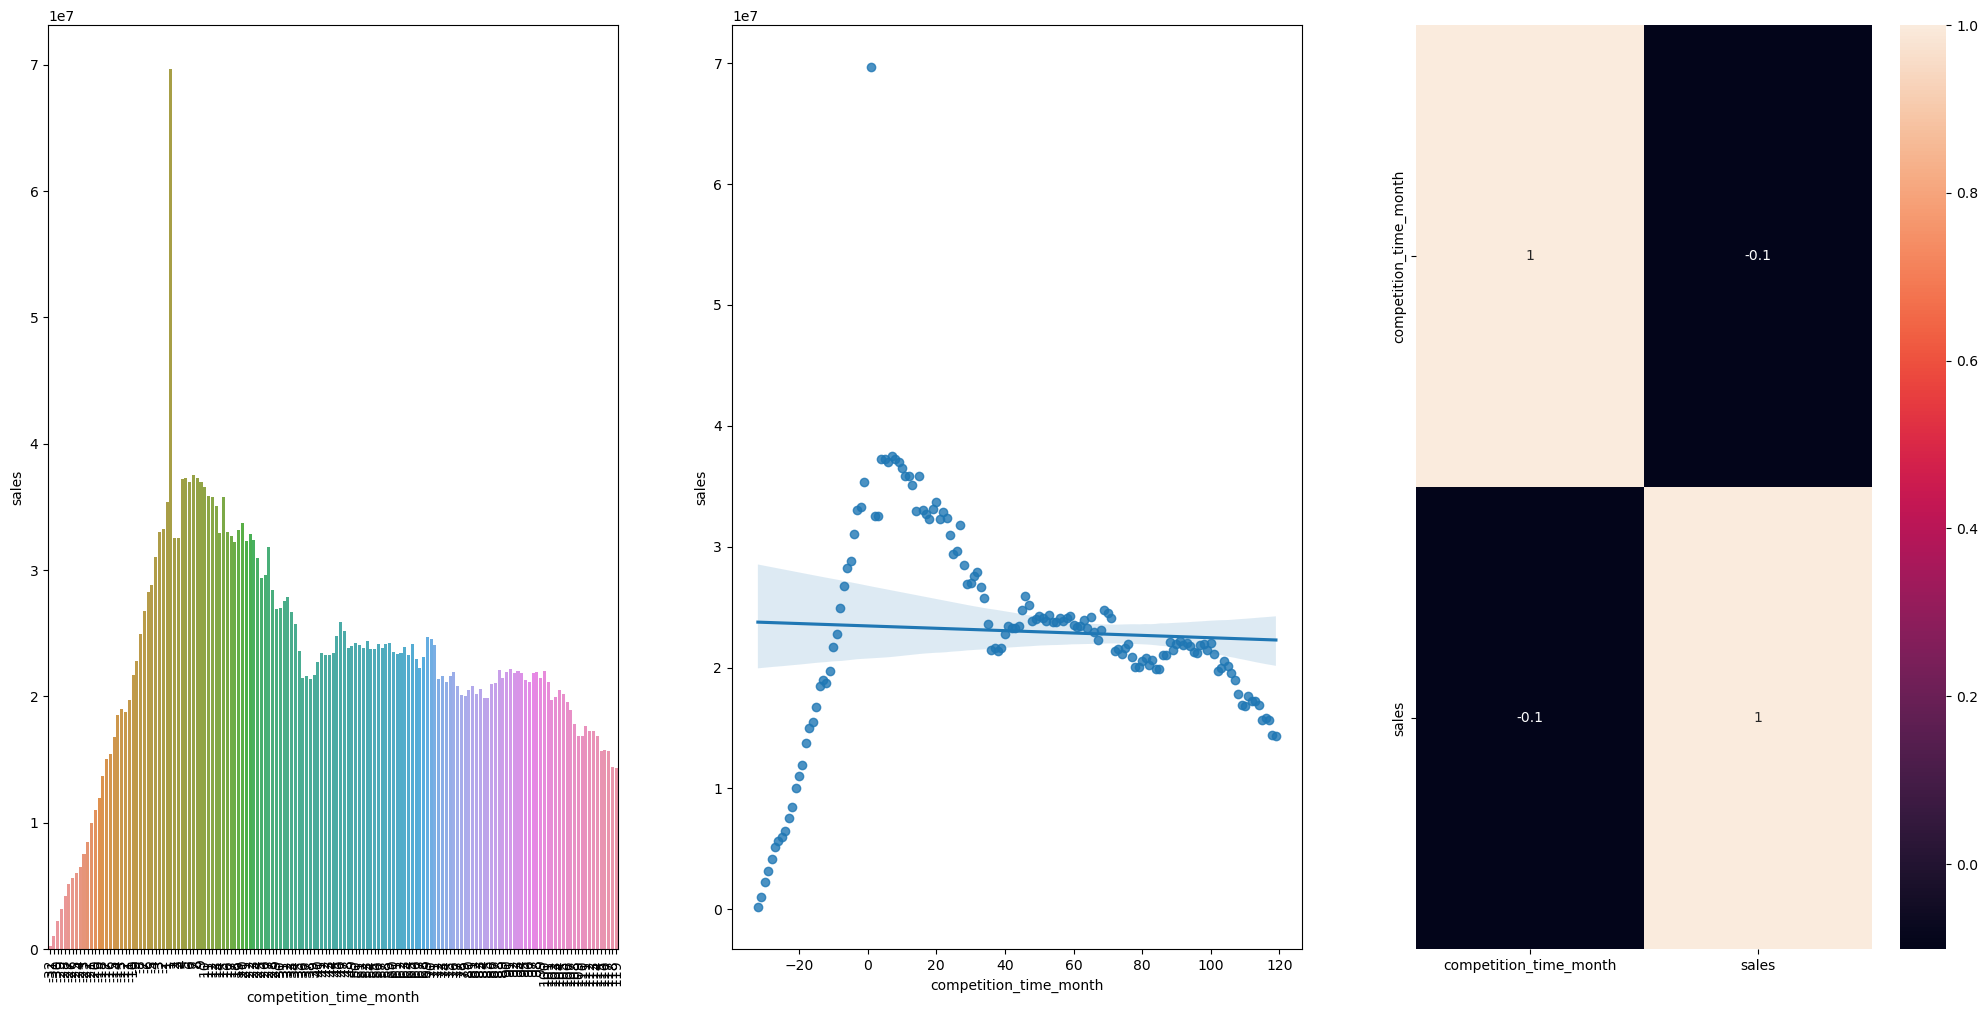

In [43]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

# Devido a granularidade, olharemos apenas os 120 primeiros meses de competição e diferente de 0.
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

# Os valores negativos são das lojas que vão abrir ainda
sns.barplot(x='competition_time_month', y='sales', data=aux2); # ; para não ficar aparecendo mesangem dos gráficos.
plt.xticks(rotation=90);
# Quanto mais recente é a competição/abertura da loja dos competidores, maior são as nossas vendas, tmb é contraditório ao senso comum - outro
# insight aqui. Dessa forma já desvalidamos essa hipótese!


# Não levar me consideração este gráfico, linha de tendência enviesada.
plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);


# Correlação entre competition_time_month e sales.
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


# Então 2 coisas:
#   Em questão de validação de hipótese, está desvalidada é Falsa!
#   E em termos de relevancia para o modelo, será uma var relevante porque tem uma correlação não tão próxima de 0.

### **H4. Lojas com promoções ativas por mais tempo deveriam vender mais.**
**FALSA** - Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.

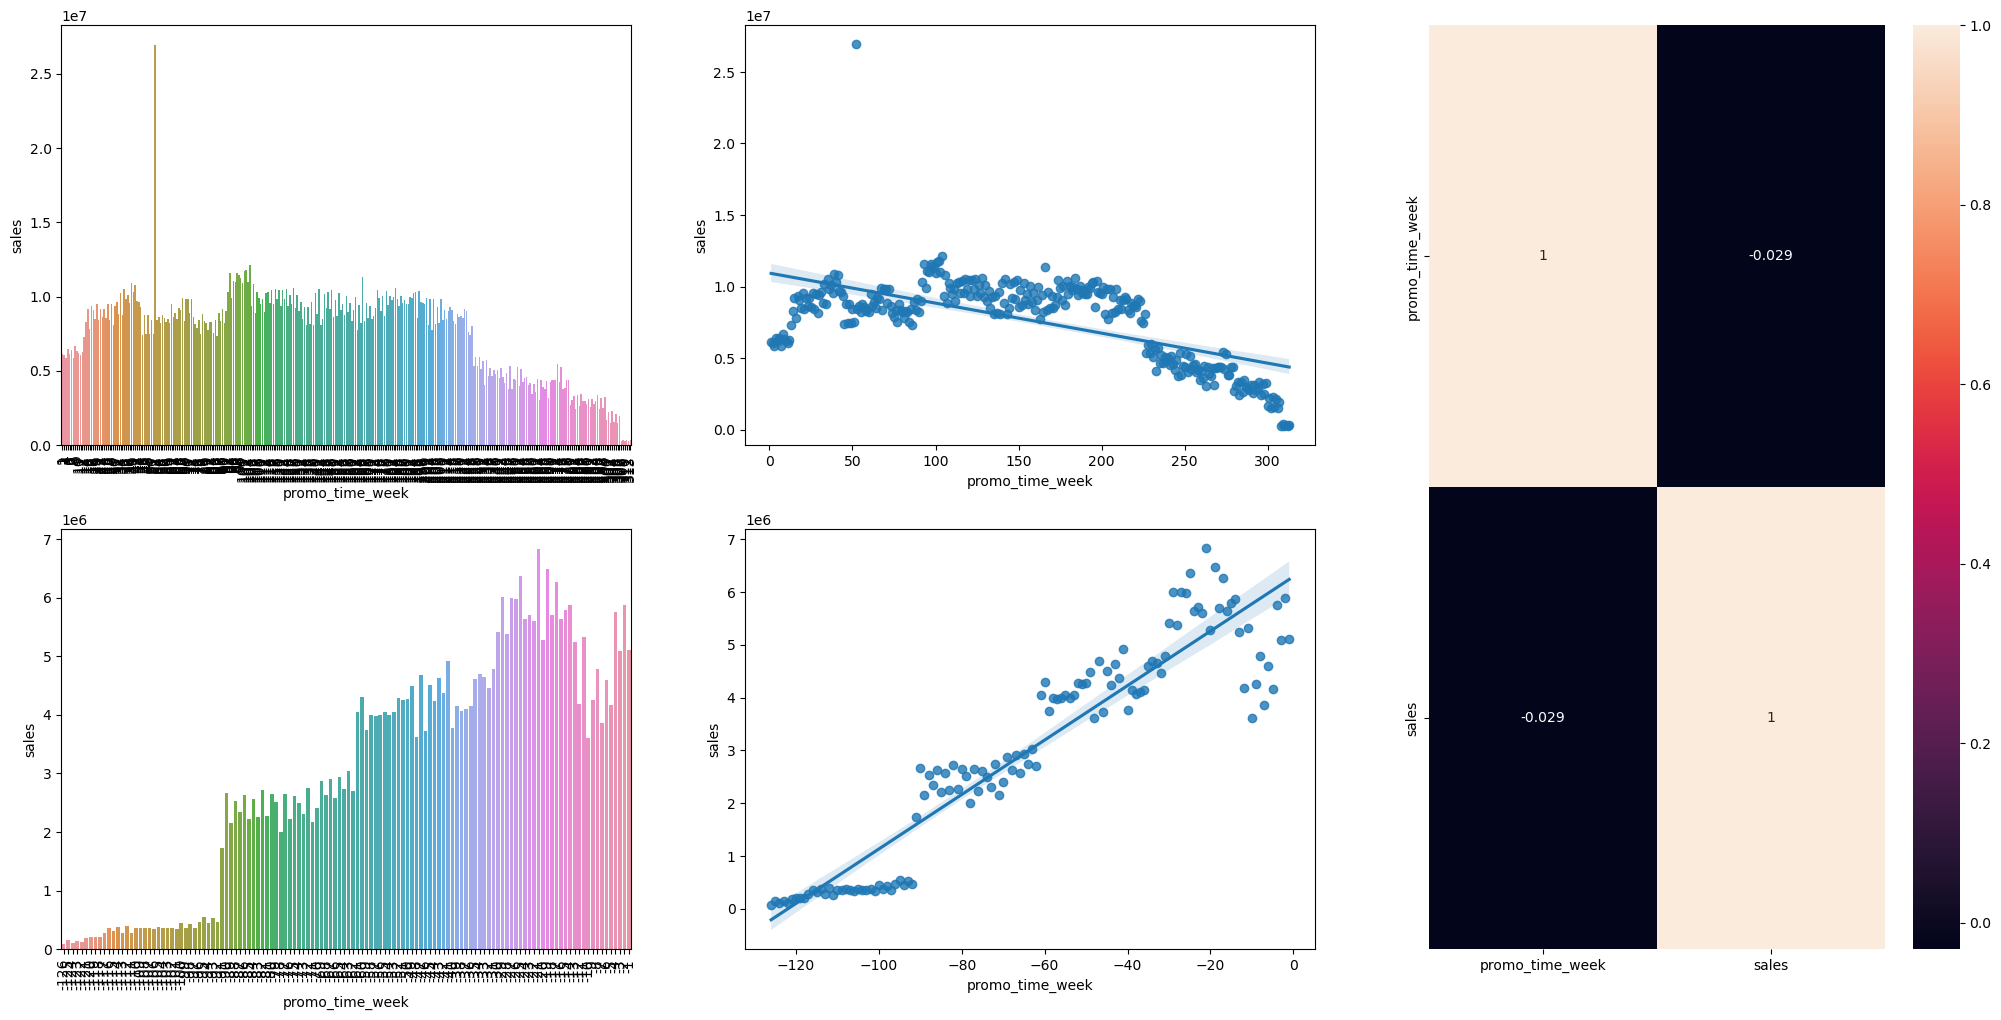

In [44]:
# negatives promo time week: sales traditional period of promotions
# positive promo time week: extended promo period sales

aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s> **H5. Lojas com mais dias de promoção deveriam vender mais.** </s>

In [45]:
# Due to the similarity with Hypothesis 4 and the current phase of CRISP, it will be revisited in the second cycle. 

### **H6. Lojas com mais promoções consecutivas deveriam vender mais.**
**FALSA** - Lojas com mais promoções consecutivas vendem MENOS!

In [46]:
# A statement

df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index() 

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


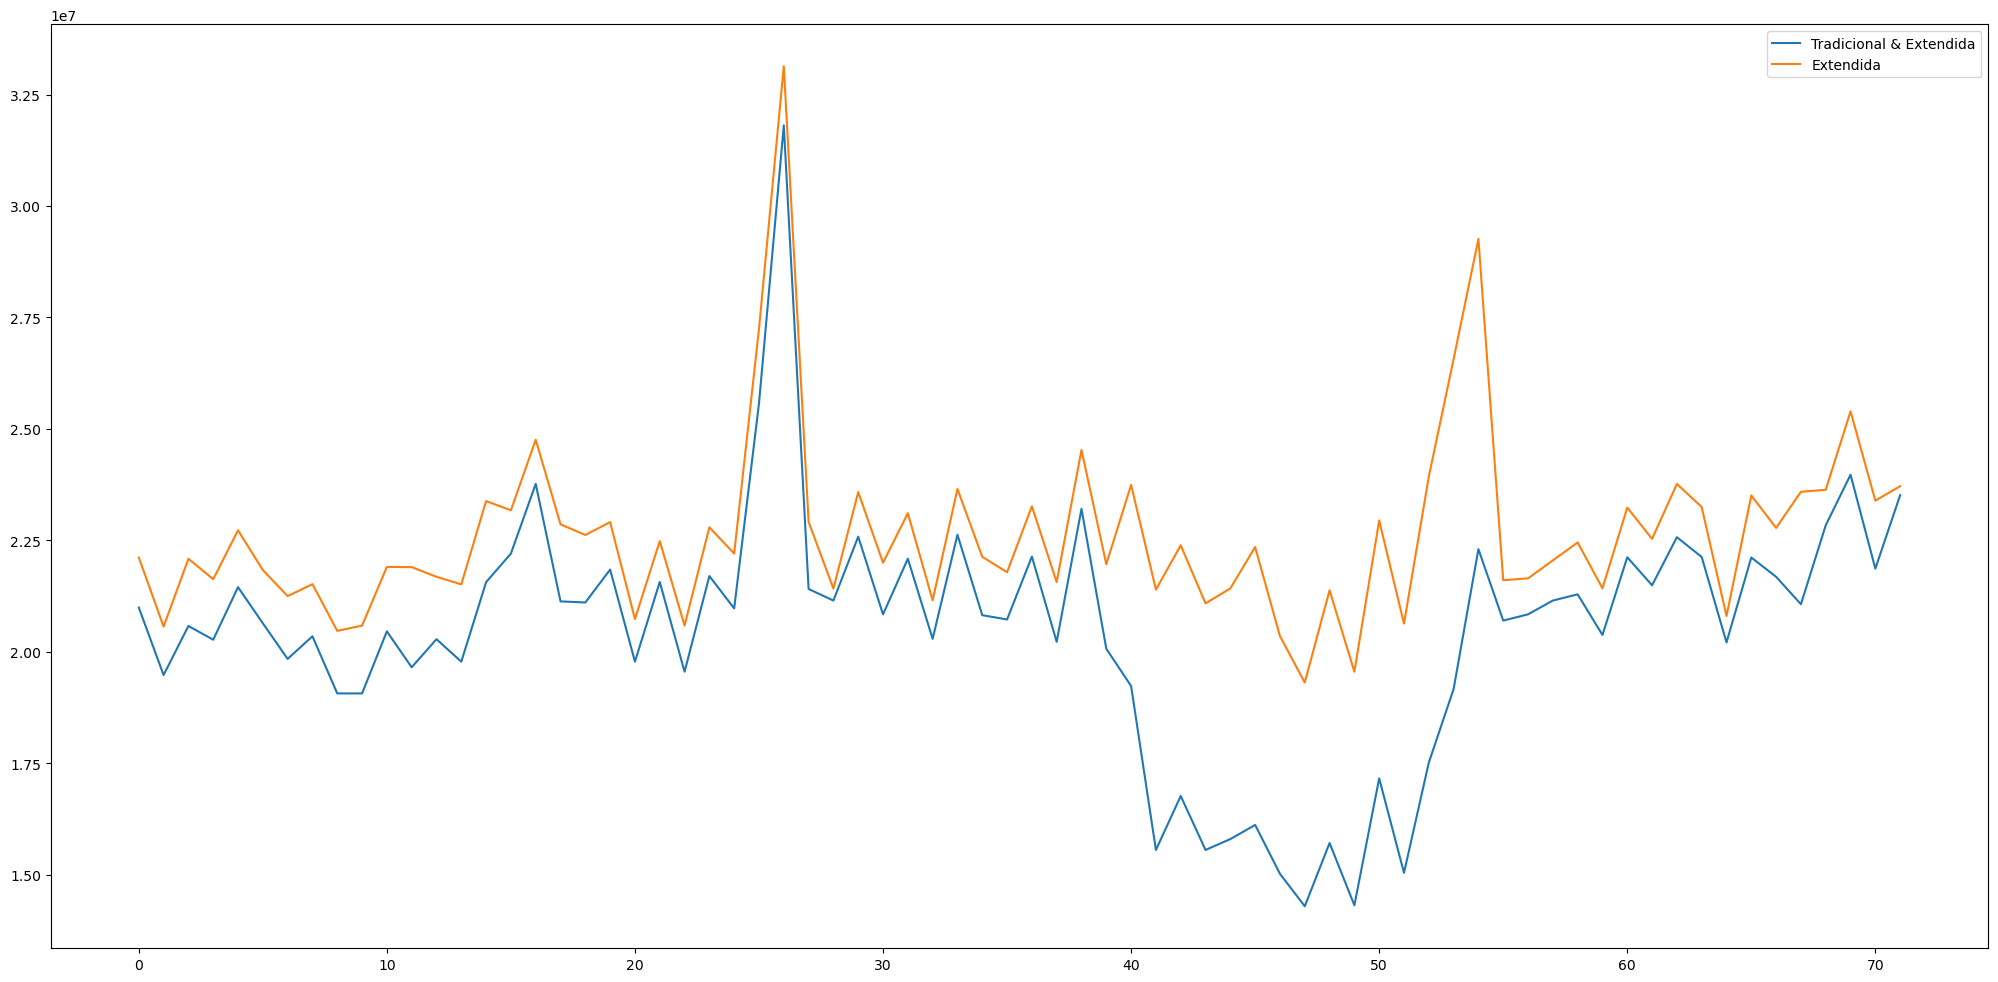

In [47]:
# But has that changed over time?

aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()

# The ax = ax is used to overlay/ superimpose the graph onto another one.
aux2.plot( ax=ax )
ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** - Lojas abertas durante o feriado do Natal vendem MENOS.

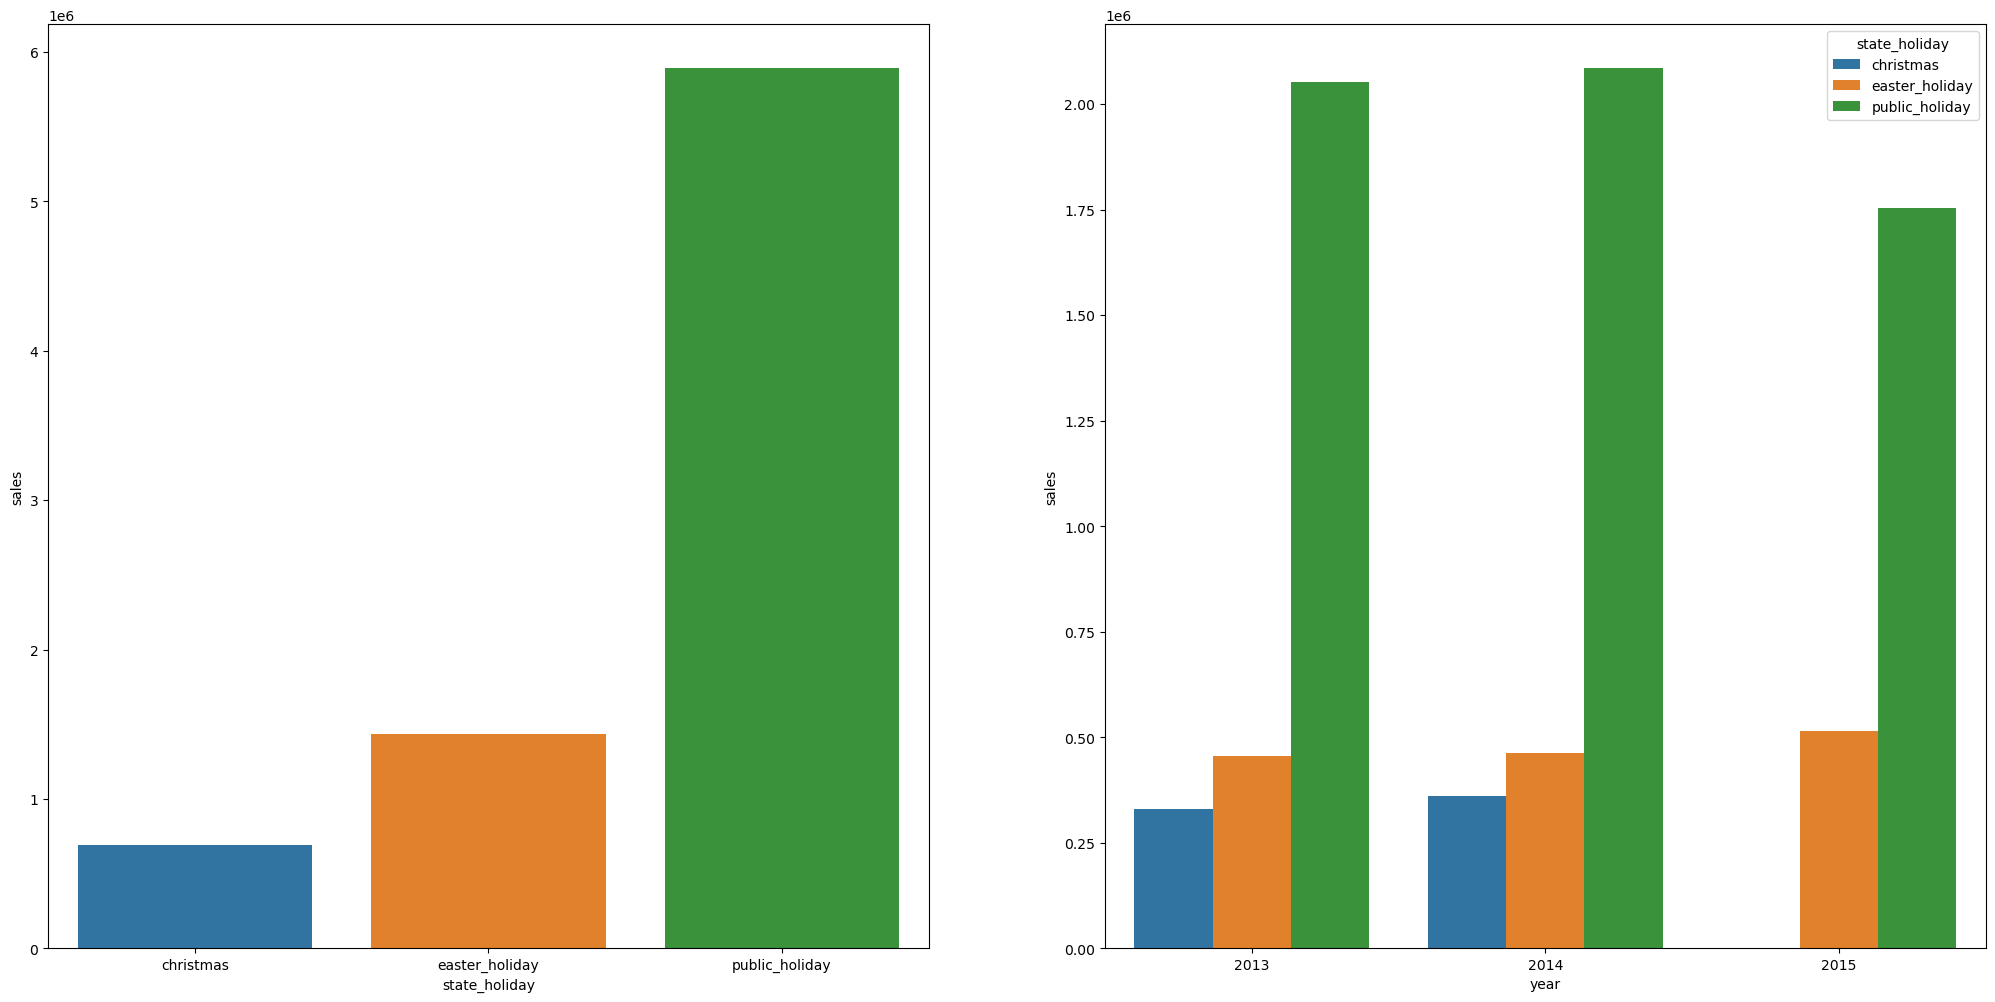

In [48]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );


#Ao longo dos anos
plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** - Lojas vendem MENOS ao longo dos anos.

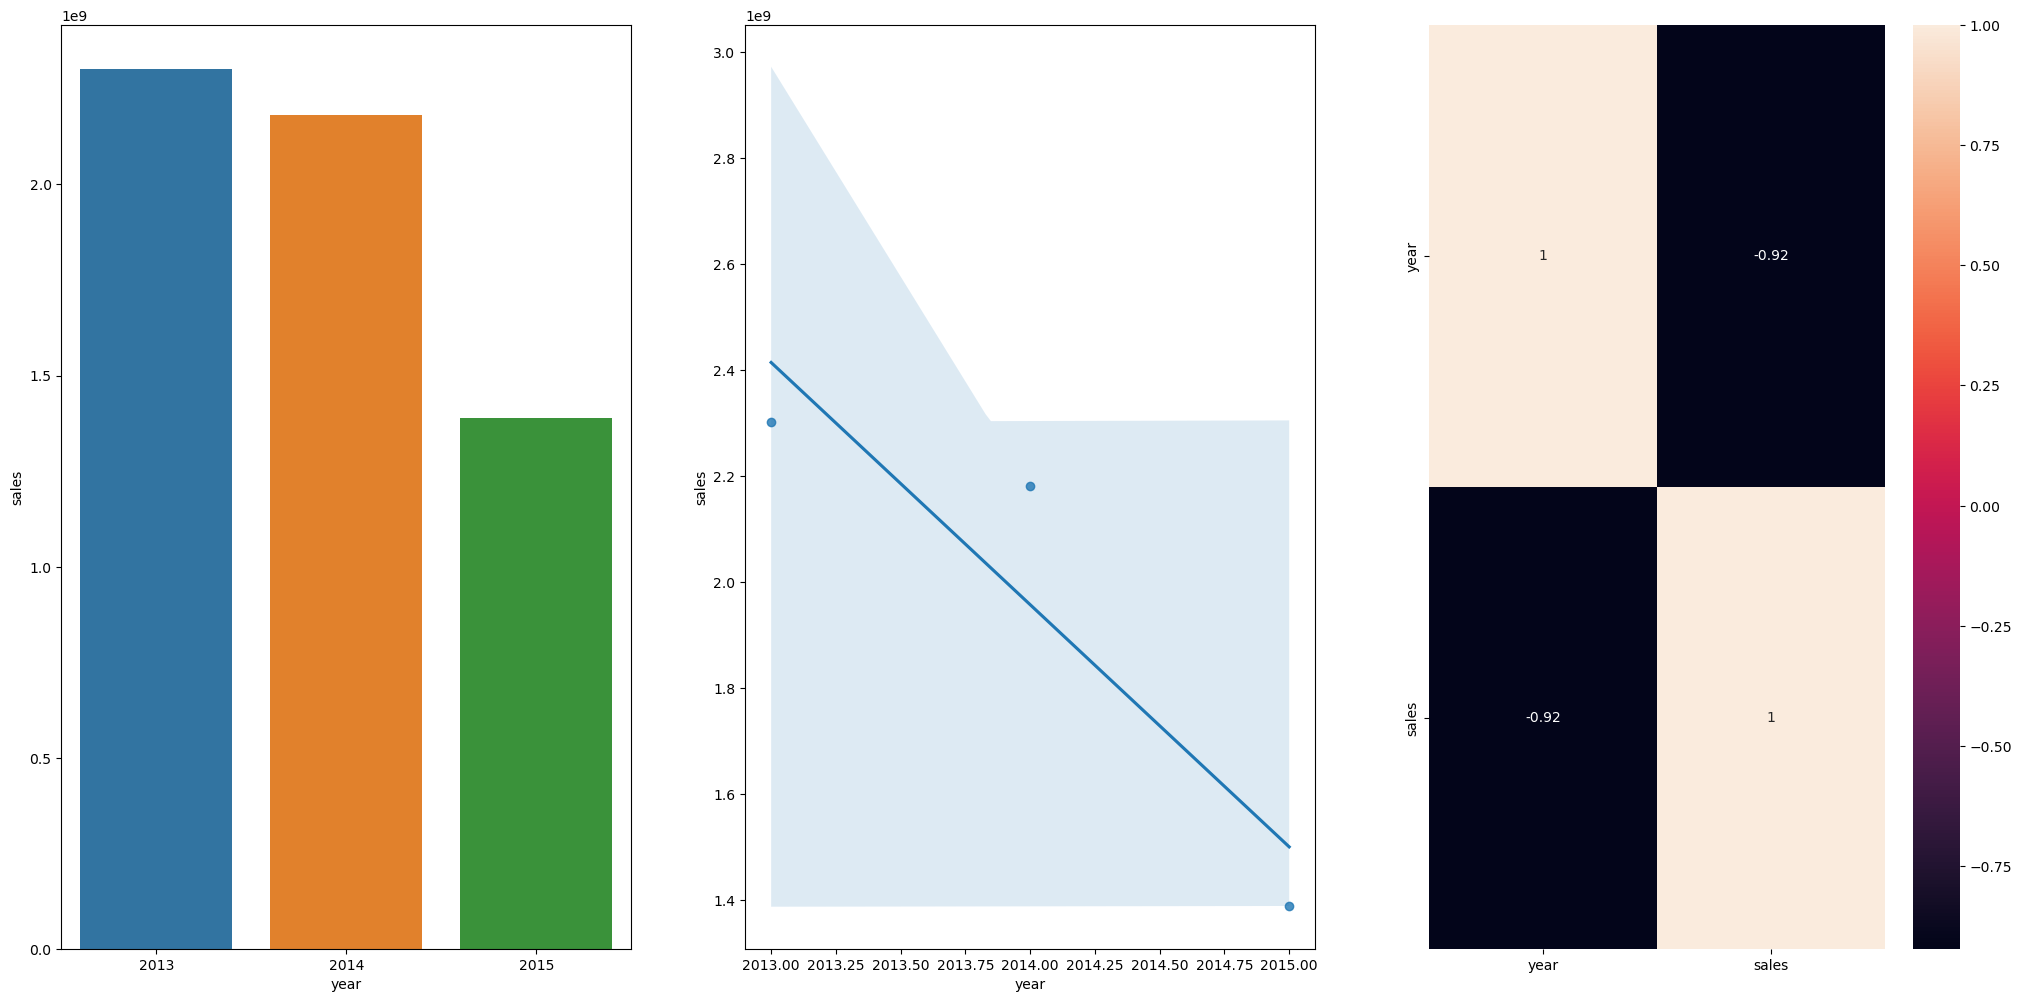

In [49]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** - Lojas vendem MENOS no segundo semestre ano!

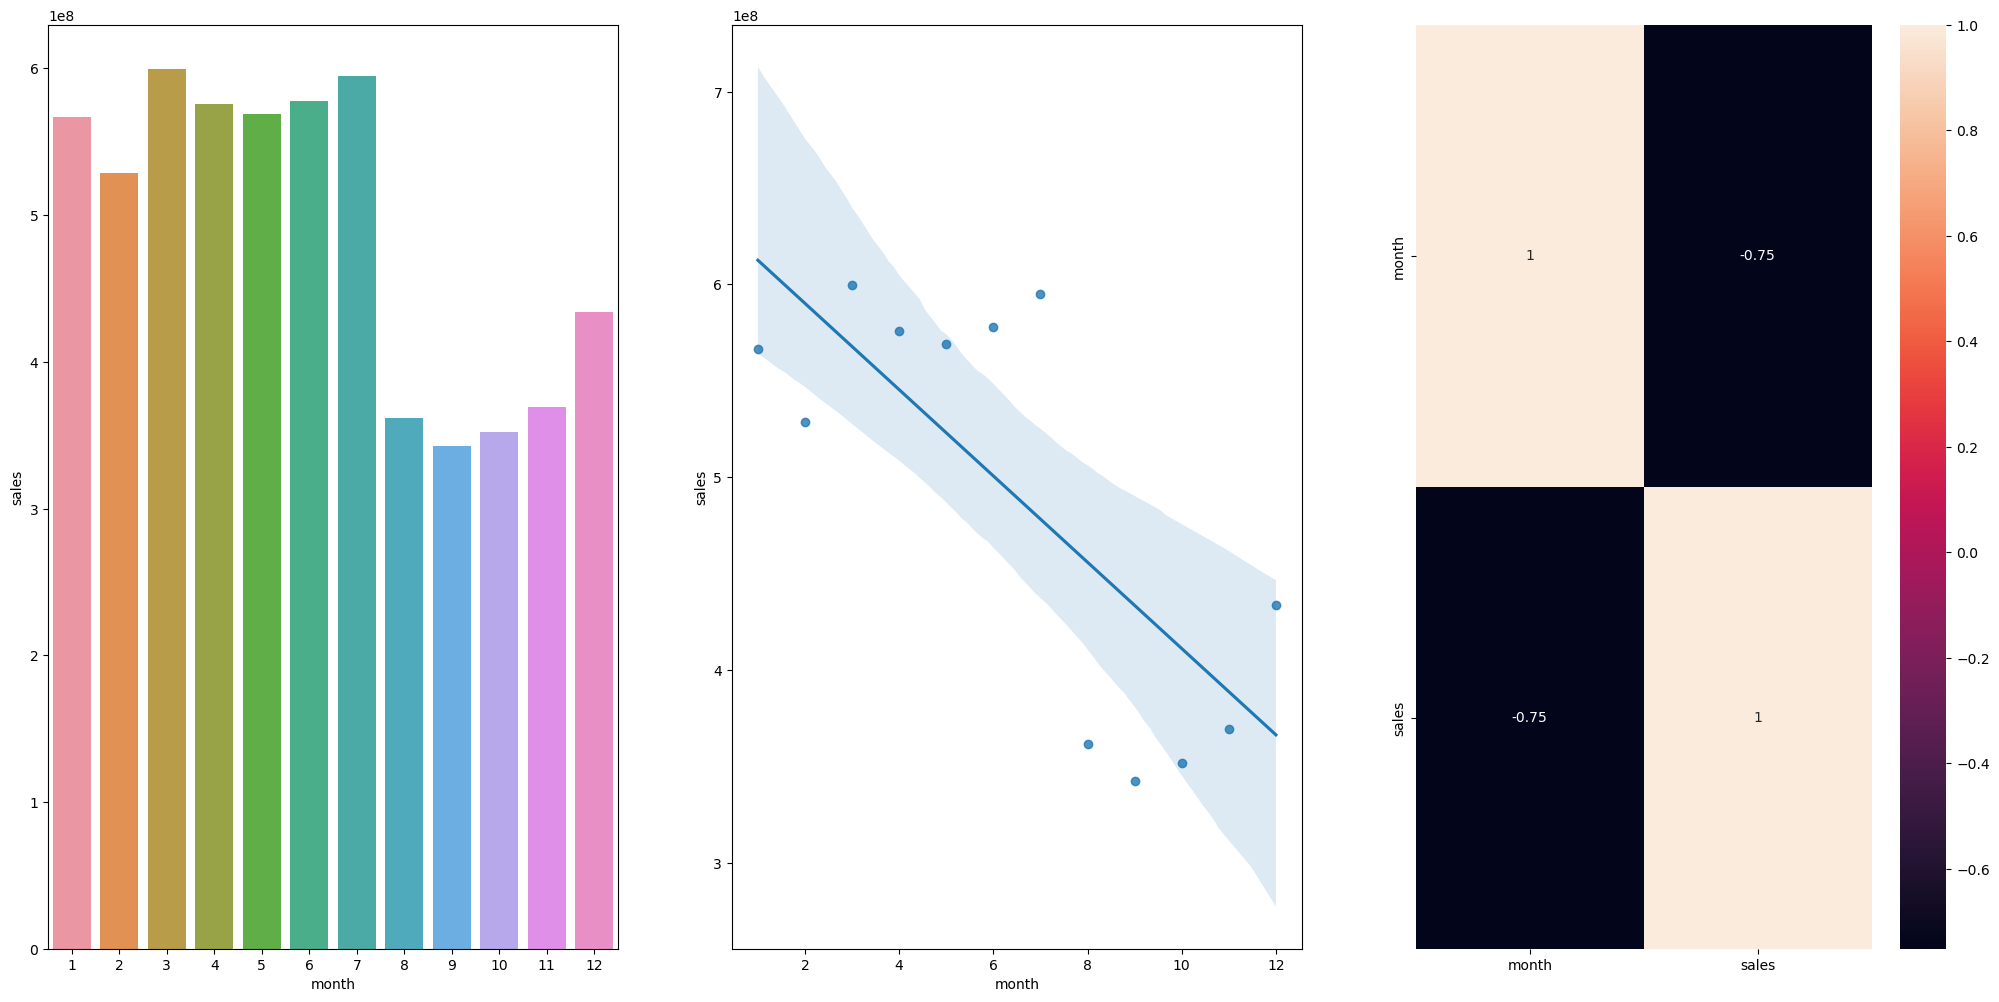

In [50]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

# In the second half of every year, Rossman sells less, it will certainly be an important variable for the model, 
# as it has a very strong negative correlation.

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** - Lojas vendem mais depois do dia 10 de cada mês.

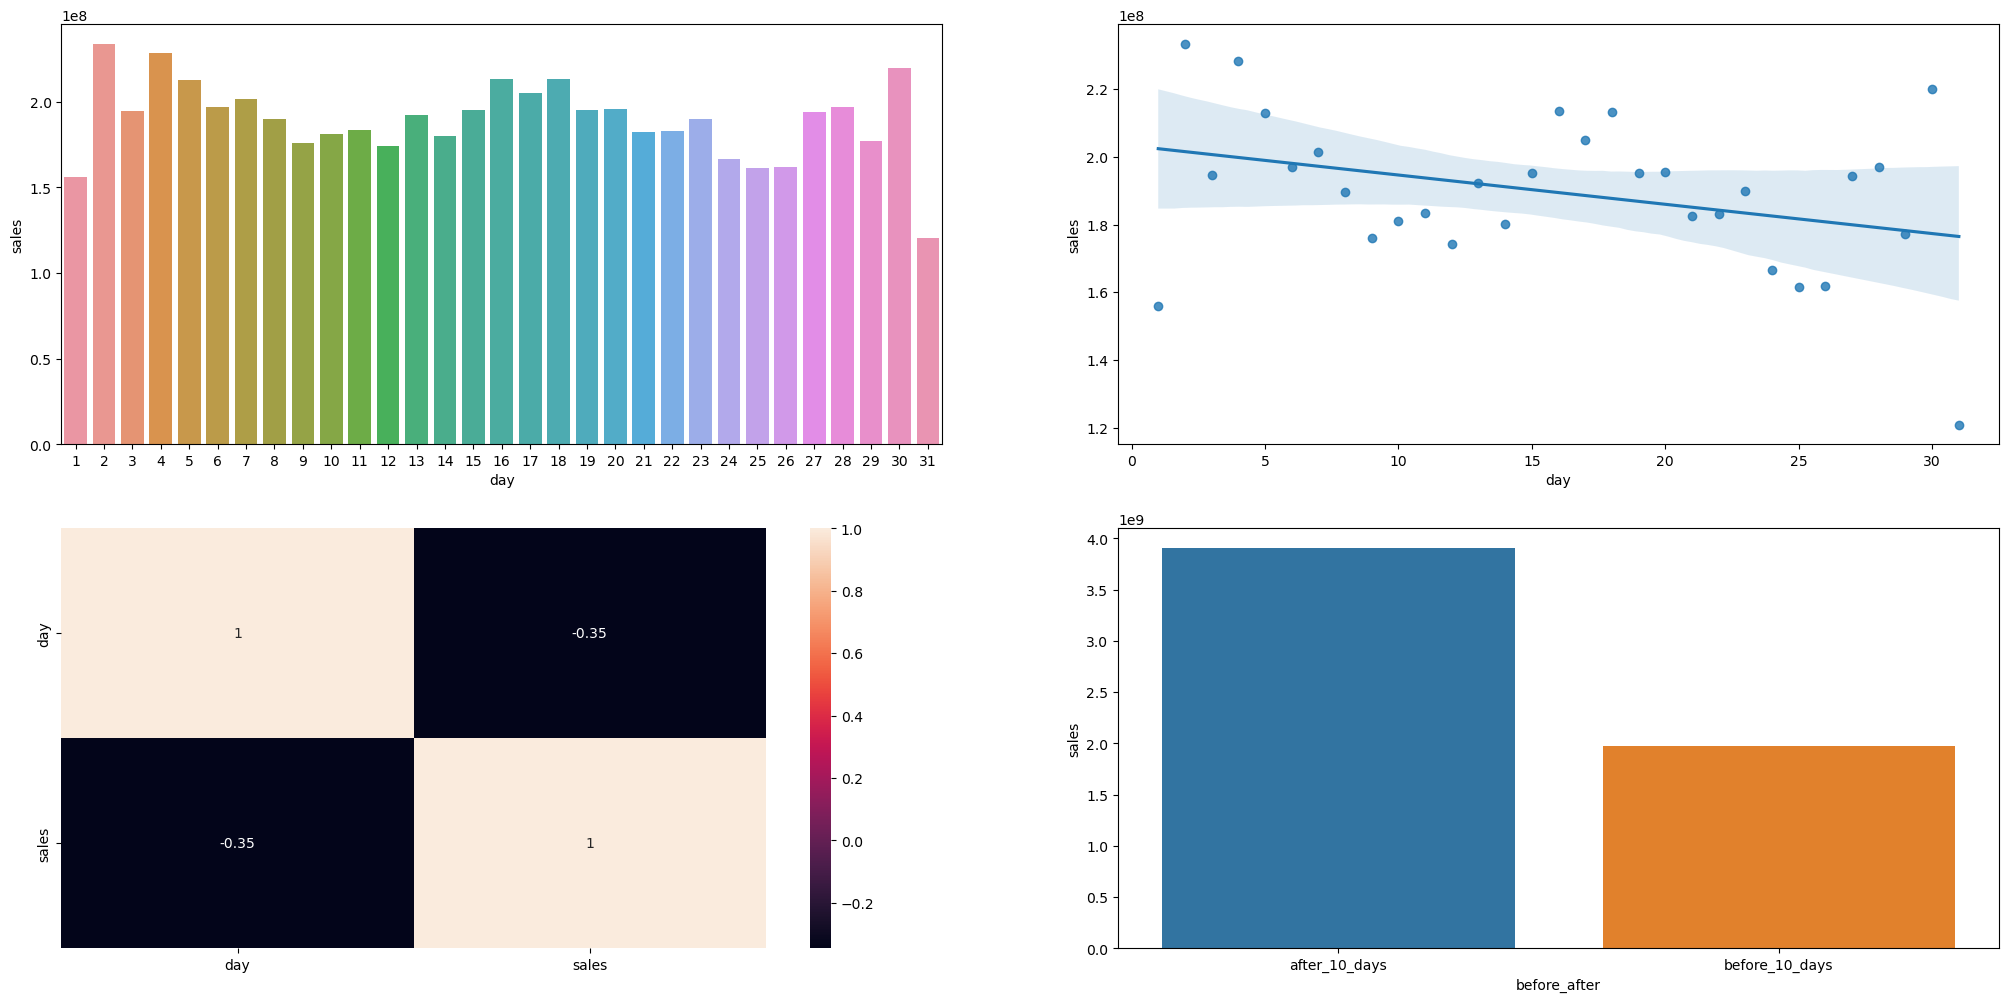

In [51]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** - Lojas vendem menos aos finais de semana.


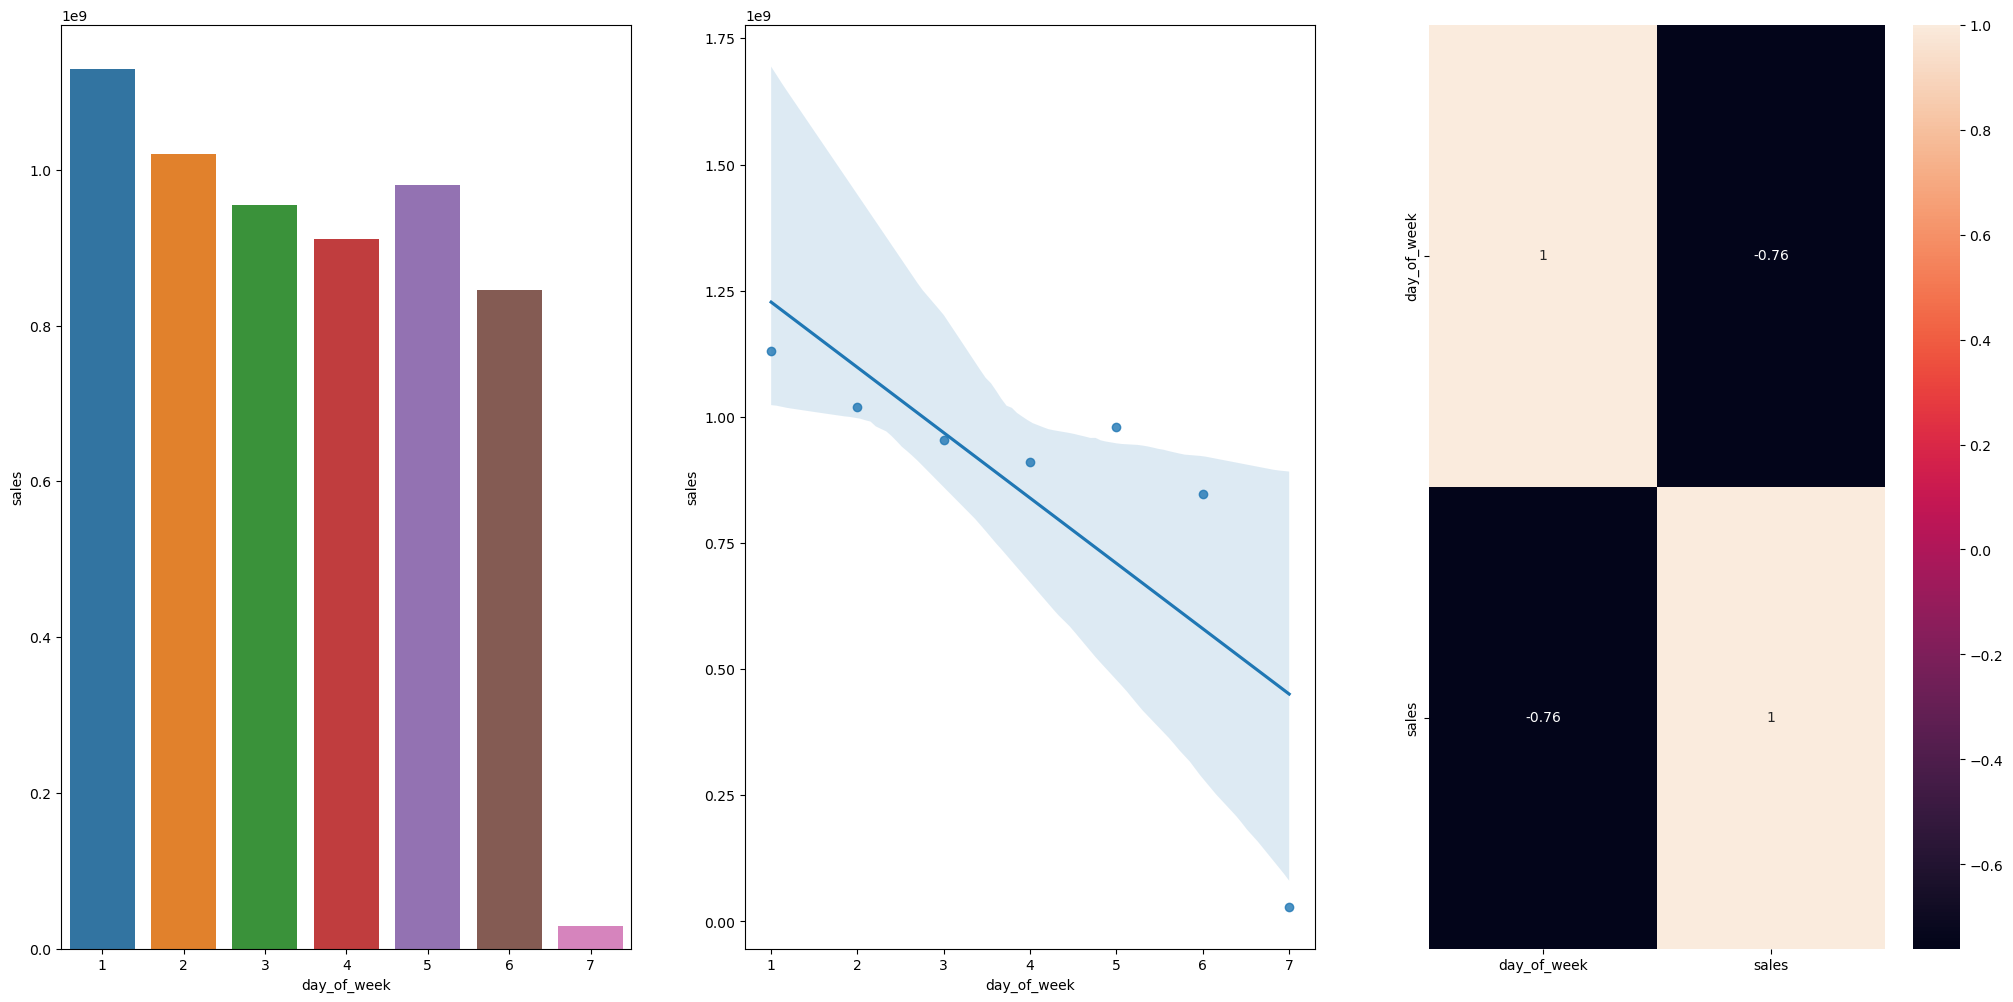

In [52]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** - Lojas vendem menos durante os feriaods escolares, exceto os meses de Julho e Agosto. 

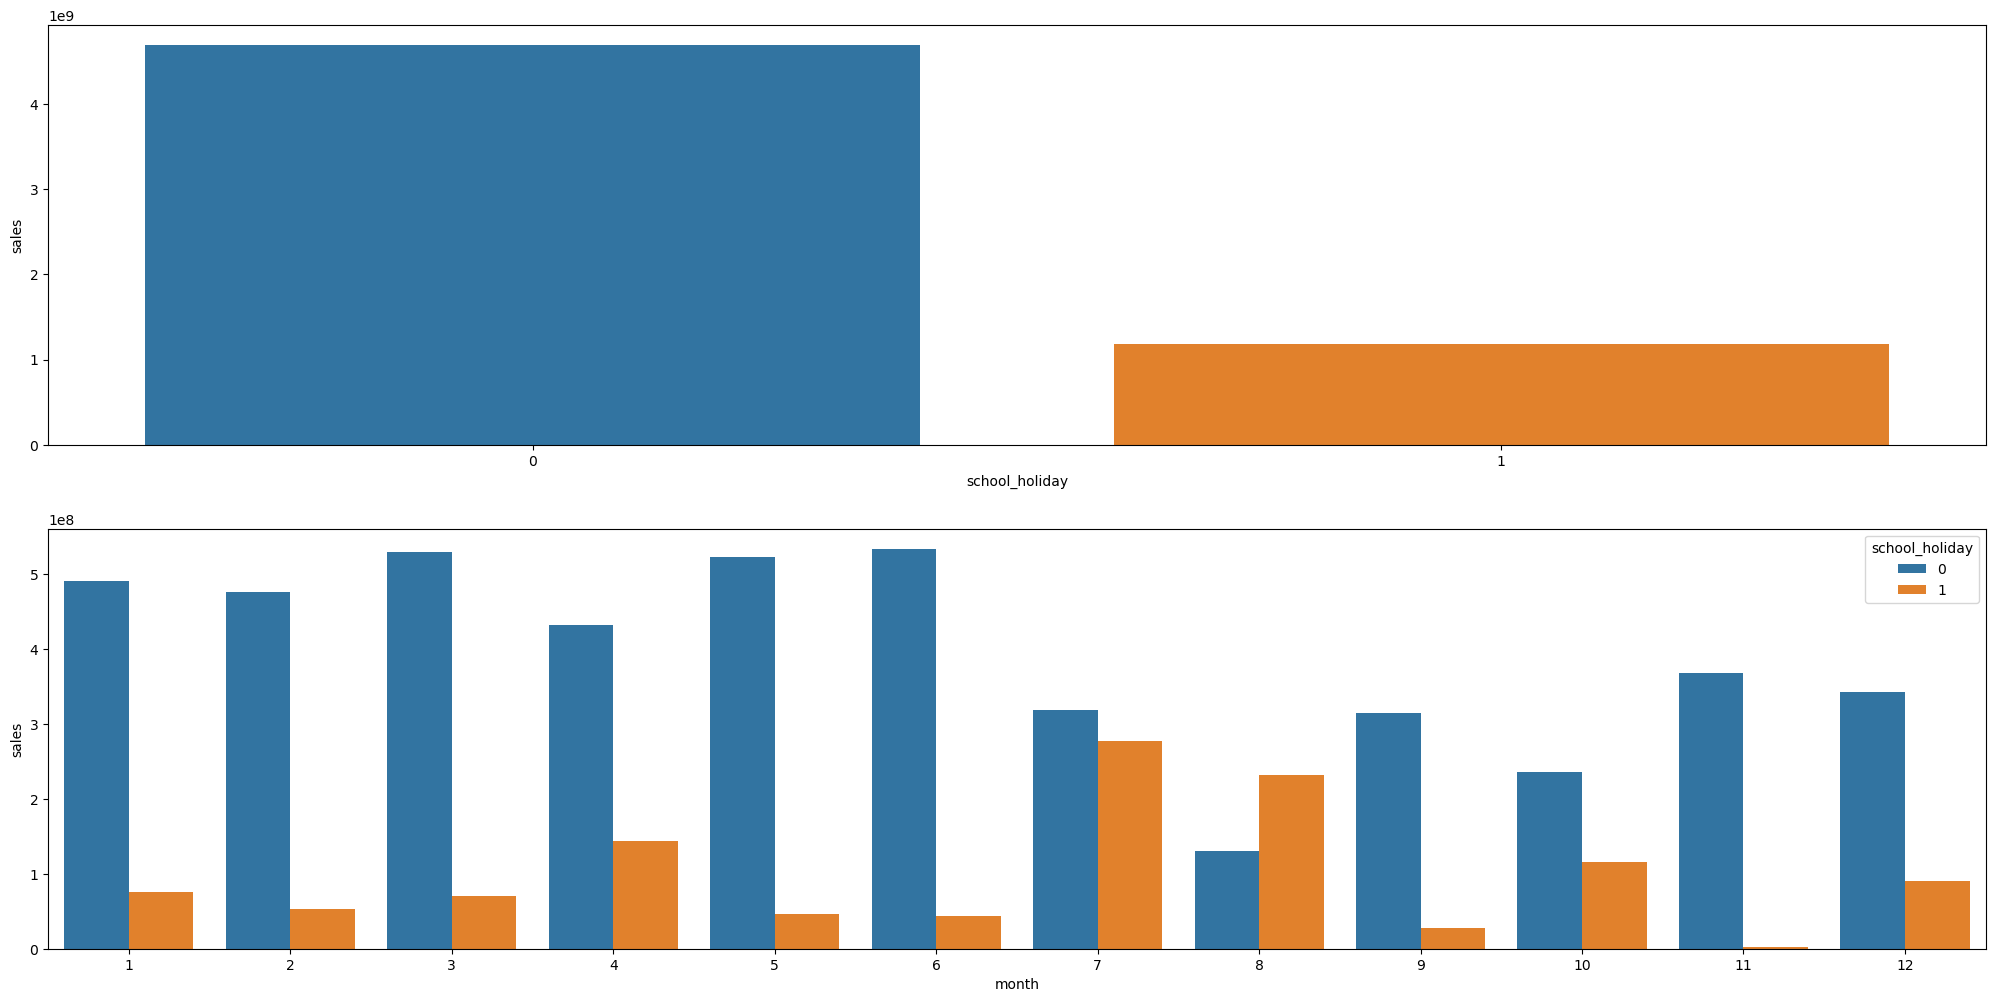

In [53]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).sum().reset_index()

plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### 4.2.1 Resumo das Hipoteses

In [54]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Media'],
['H8', 'Falsa', 'Alta'],
['H9', 'Falsa', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

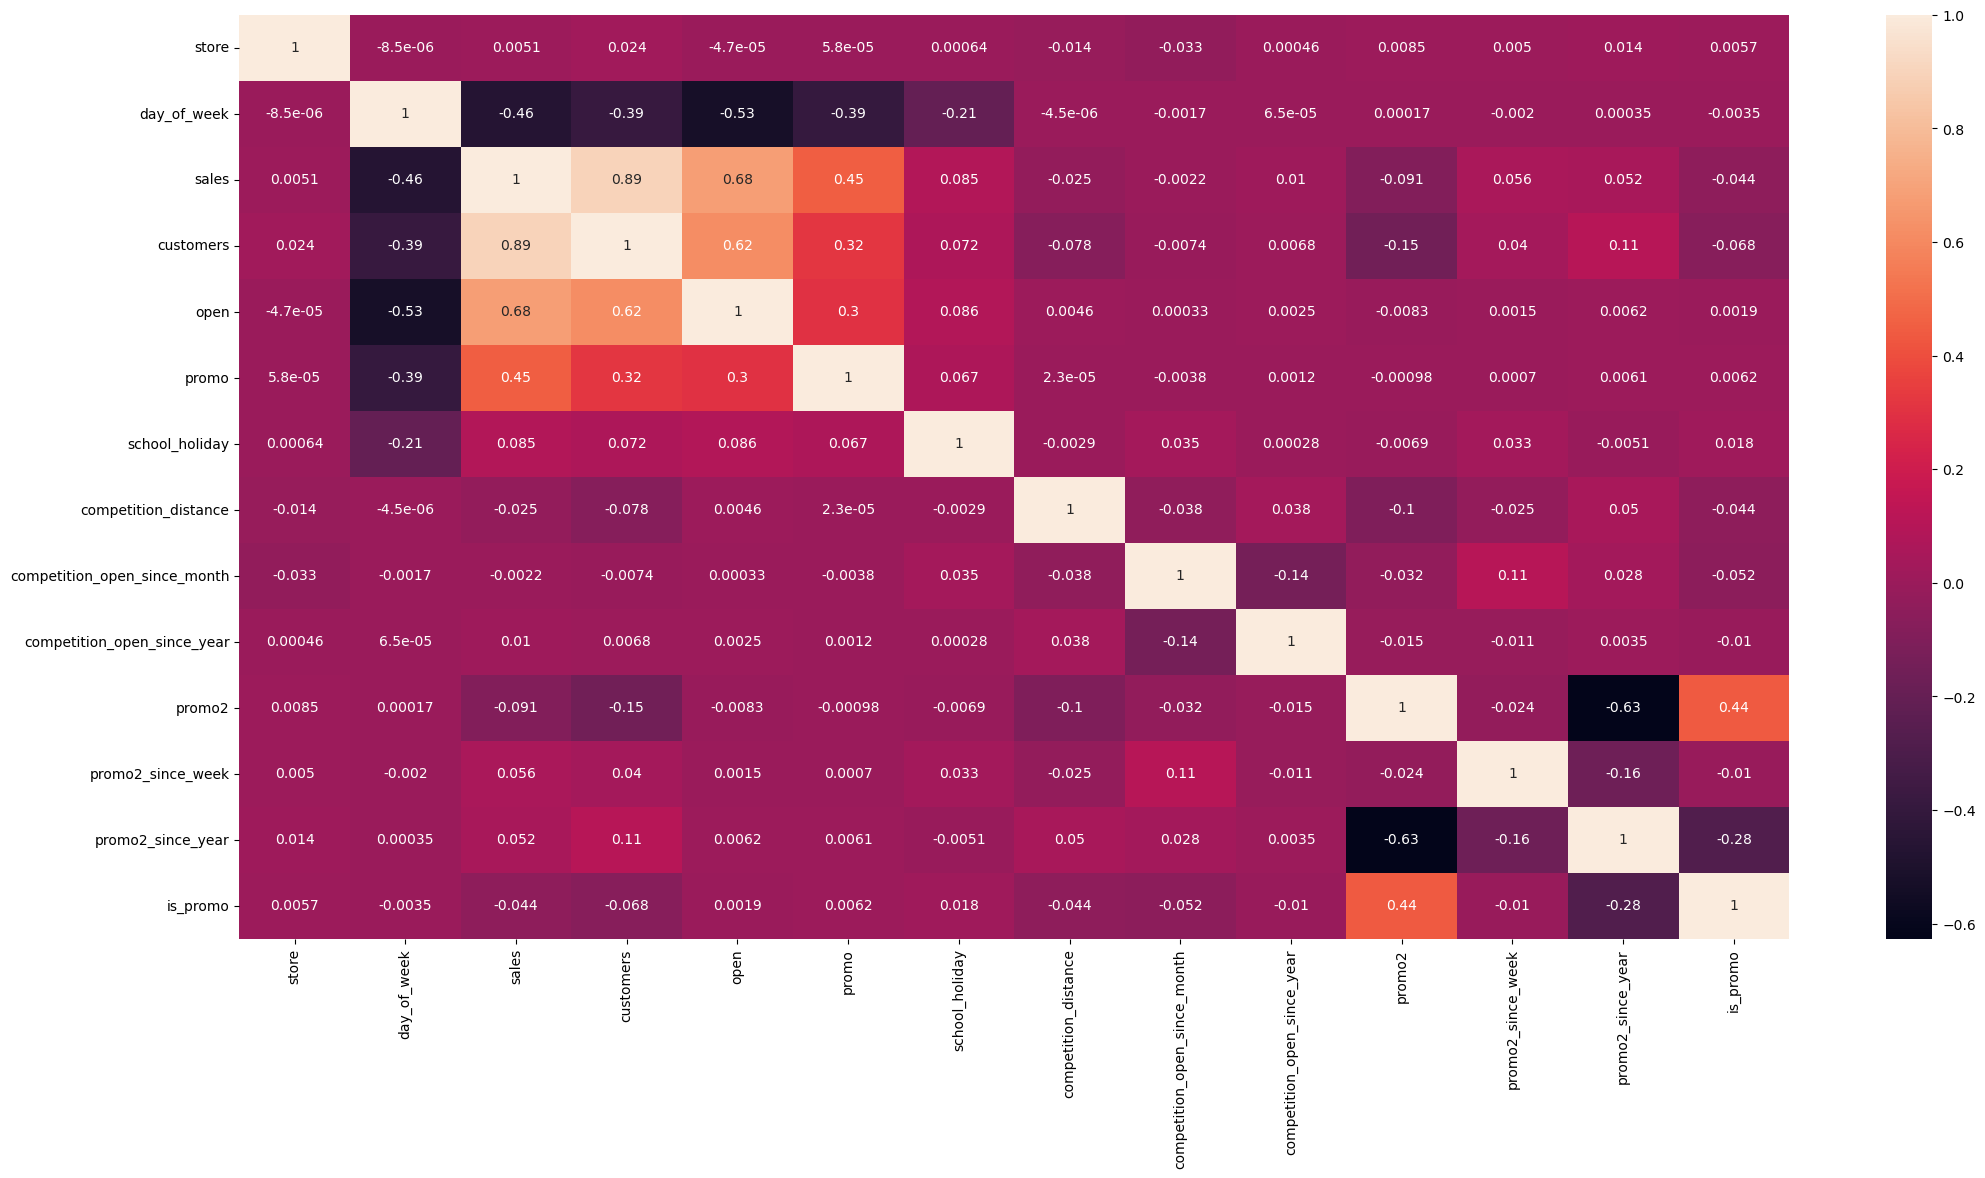

In [55]:
# Multivariate correlation matrix

correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

In [56]:
# Pearson is a statistical test used to calculate the correlation between two numerical variables. It is suitable when both variables are numerical.
# However, when the variables are categorical, it is not appropriate to use the Pearson test, even if one variable is categorical and the other is
# numerical. In these cases, the recommended method is Cramér's V, which is used to measure the association between categorical variables.

# Only categorical data
a = df4.select_dtypes(include='object')

a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [57]:
# Calculate Cramer V

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({ 'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9], })


# Final dataset
d = d.set_index(d.columns)
d

# The closer to 0, the lower the correlation. 
# The closer to 1, the greater the correlation.

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<AxesSubplot: >

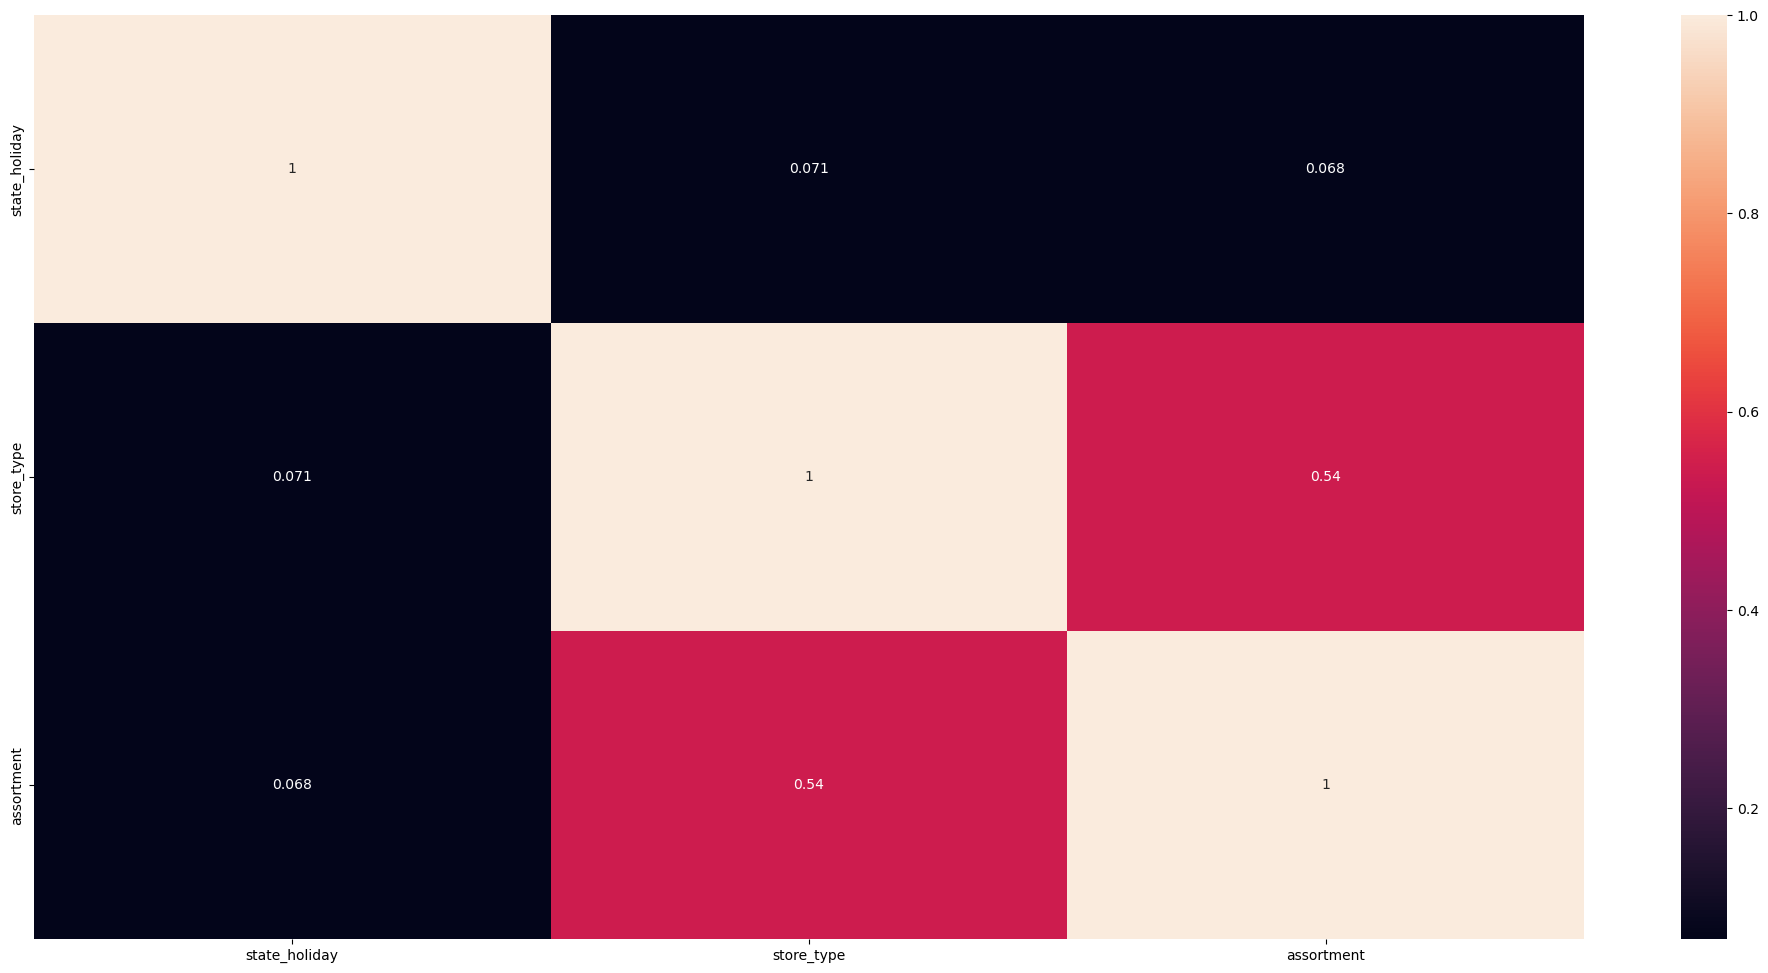

In [58]:
# Correlations between categorical vars
sns.heatmap(d, annot=True)

# The variable 'store_type' has a strong correlation with 'assortment', which makes sense. The larger the store type, the more items it can accommodate, and 
# the greater the variety of products it can offer. This relationship is supported by the data, indicating that a higher 'store_type' is associated with a 
# larger 'assortment' of products.

# 5.0 Data Preparation - (Step 5)

In [59]:
df5 = df4.copy()

## ~~5.1 Normalização~~

In [60]:
# Perform rescaling, since variables with normal distribution were not found in topic 4.1.2,
# avoiding the need for forced normalization.

## 5.2 Rescaling

In [61]:
# Identify vars that I will apply Rescaling
a = df5.select_dtypes(include=['int64', 'float64'])
a.head()

# Are they:
#   competition distance
#   year
#   competition time month
#   promo time week
#   month
#   day
#   week of year

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31


<AxesSubplot: >

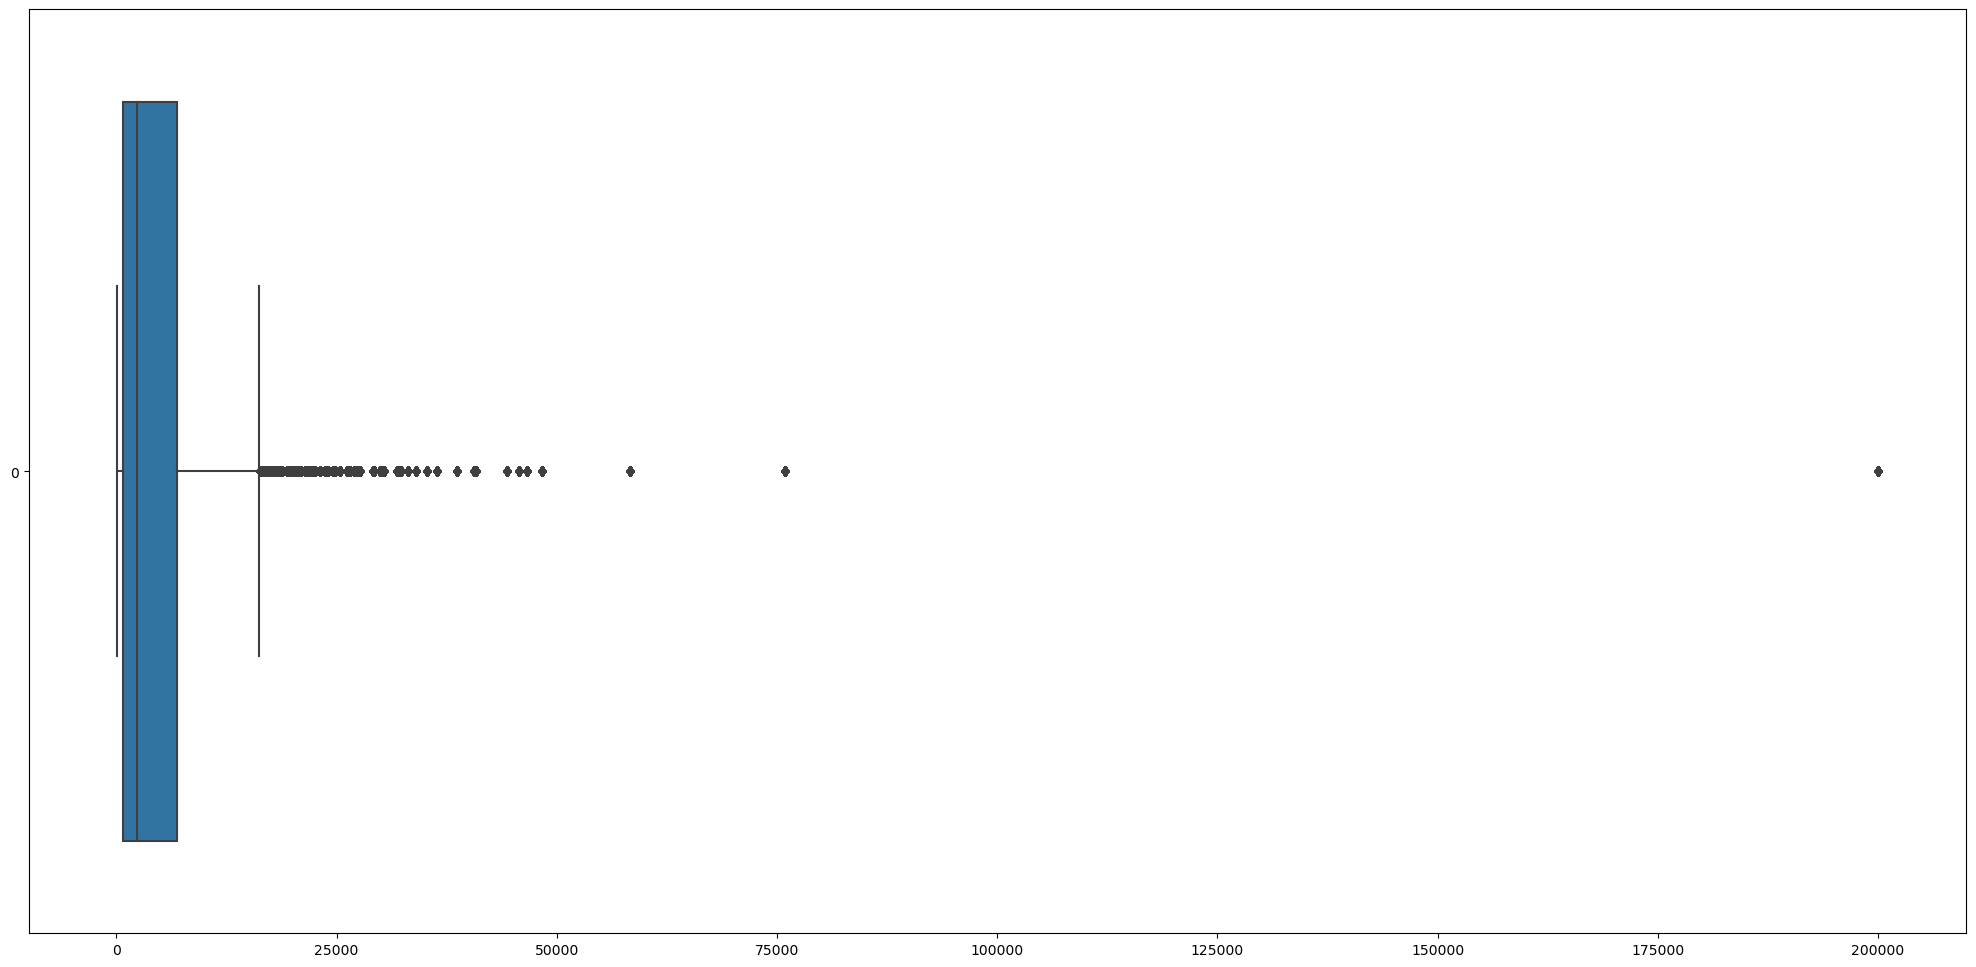

In [68]:
# No cyclical nature:
#   competition distance
#   year
#   competition time month
#   promo time week

# To decide between using MinMaxScaler or RobustScaler, evaluate the presence of significant outliers in your data using boxplot and apply each technique
# in the corresponding columns.

sns.boxplot(df5['competition_distance'], orient='horizontal') #competition distance

# MinMaxScaler: sensitive to outliers
# RobustScaler: more robust option for data with outliers

In [ ]:
# Use RobustScaler and MinMaxScaler for non-normal/Gaussian vars

# Instantiate
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance - relevant outliers so I used the rs.
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month - relevant outliers so I used the rs.
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week - outliers not so relevant so I used the mms.
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

# year - no outliers so I used the mms.
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') ) 

# Power of Rescaling, now we have the same data in the same shape in a new range and with equivalent values to use in the model.

C:\Users\andre\AppData\Local\Temp\ipykernel_29684\606226789.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df5['competition_distance']);


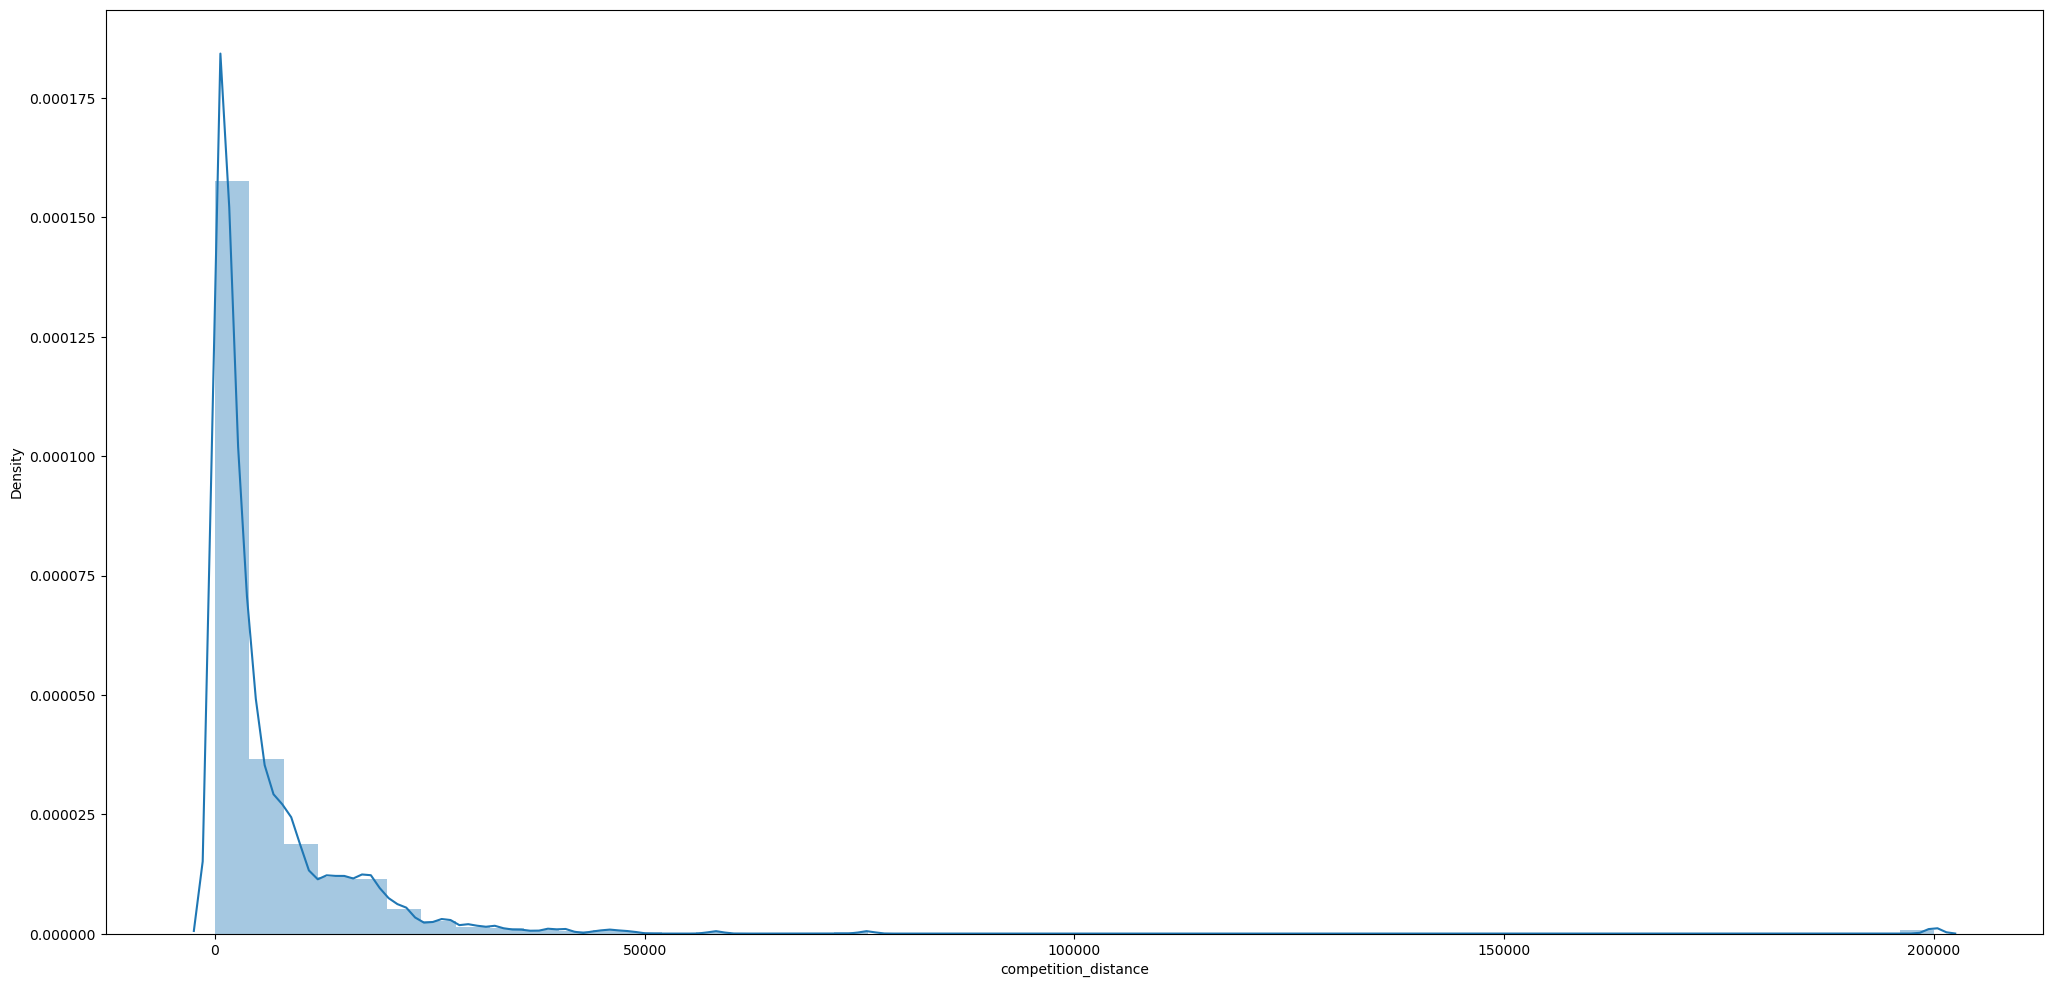

In [69]:
# Verificando
sns.distplot(df5['competition_distance']);

# You can go back to topic "4.1.2 Numerical Variable" and observe that the format is the same, but in a different scale.

In [70]:
# See the values of the competition distance column
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [71]:
# See that it changes column values such as competition_distance
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 5.3 Transformação

### 5.3.1 Encoding

In [ ]:
# state_holiday - I used One Hot Encoding (moments when behavior changes)

df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])


#------------------------------------------------------------------------------------------------------------------------------------
# store_type - I used Label Encoding (there is no order)

#Instanciar a classe:
le = LabelEncoder()

df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open( 'parameter/store_type_scaler.pkl', 'wb'))


#------------------------------------------------------------------------------------------------------------------------------------
# assortment - I used Ordinal Encoding (there is a sort of order in the assortment) 

assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [ ]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.2 Response Variable Transformation

In [ ]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation

In [73]:
# Vars of cyclic nature

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2.* np.pi/30 )))
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2.* np.pi/30 )))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 )))
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 )))

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )))
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 )))
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 )))

# 6.0 Feature Selection - (Step 6)

In [ ]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset


In [ ]:
# Before carrying out the division (split), it is necessary to exclude the original variables that were transformed into new derived variables, 
# ensuring that there is no duplication of information.

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [ ]:
'''
Due to the temporal problem, it is necessary to divide the data into training and test sets, respecting the temporal order, 
to avoid using future information in training. In this sense, the last 6 weeks are reserved for testing, 
while the previous weeks are used for training.
'''

# Checking dates

# start
df6[['store', 'date']].groupby('store').min().reset_index()

# end
df6[['store', 'date']].groupby('store').max().reset_index()

# Date starting 6 weeks before the end.
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

# Result: first date of 6 weeks is 2015-06-19.

Timestamp('2015-06-19 00:00:00')

In [ ]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format( X_train['date'].min() ))
print('Training Max Date: {}'.format( X_train['date'].max() ))
print('Test Min Date: {}'.format( X_test['date'].min() ))
print('Test Max Date: {}'.format( X_test['date'].max() ))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00
Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector


In [ ]:
# Training and test dataset for Boruta
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()


#--------------------------------------------------------------------------------------------------------------------------------------------
# Define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 ) # all machine cores


#--------------------------------------------------------------------------------------------------------------------------------------------
# Define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

# Iteration 
# Confirmed: shows how many vars boruta has already confirmed as being relevant to the model.
# Tentative: these are vars that boruta had doubts about, he was unable to classify them as relevant or not in this iteration.
# Rejected: vars that it has already rejected and considered to be NOT relevant to the model.

### 6.2.1. Best Features from Boruta

In [ ]:
# boruta support - relevant rank value
cols_selected = boruta.support_.tolist()


# Best features

# xtrain fs(feature selection)
X_train_fs = X_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# Not selected Boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3 Manual Feature Selection

In [ ]:
'''
 Note:
    I performed a cross check between the variables found by Boruta and those considered relevant in the EDA. In case of contradiction, 
    I prioritize Boruta's suggestions in the first iteration of the CRISP cycle, but in the second iteration I can add the relevant EDA 
    variables to assess possible improvements in model accuracy.
'''

# Saving the results to avoid running the script again
cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
# Added to the list sin month and sin year 


# columns to add
feat_to_add = ['date', 'sales'] 
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 Machine Learning Modelling - (Step 7)

In [ ]:
# Train and test - without date e sales

x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]
# Remembering that here are the most relevant columns according to boruta and our experience as well.

# Train with date and sales
x_training = X_train[cols_selected_boruta_full] 


''' Next, I will perform a single iteration of the models to identify the linearity of the problem and then proceed with cross-validation.'''

' \n\n# ESSA PRIMEIRA RODADA DOS ALGORITMOS DE ML NAS SEÇÕES ABAIXO, É APENAS PARA TER UMA NOÇÃO SE O FENOMENO É COMPLEXO OU NÃO, POIS OS RESULTADOS GERADOS\n# NÃO SÃO OS REAIS, TEM QUE FAZER O CROSS VALIDATION, FUNÇÃO CRIADA NA HELPER FUNCTIONS. \n\n'

## 7.1 Average Model

In [ ]:
aux1 = x_test.copy() # x_test = X_test[cols_selected_boruta] , that is, the x_test is WITHOUT DATE and SALES and without the irrelevant vars
aux1['sales'] = y_test.copy() # y_test = X_test['sales'] -- topic 6.1

# aux1 == X_test[cols_selected_boruta] + X_test['sales']


#---------------------------------------------------------------------------------------------------------------------------------------------
#Prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
# Sales average of all stores will be our predictions

# Merge
aux1 = pd.merge(aux1, aux2, how='left', on='store') # lojas com a as suas medias de vendas
# now: aux1 ==  X_test[cols_selected_boruta]   +   aux2['predictions'] (means)

# True value estimate, predictions
yhat_baseline = aux1['predictions']

#Performance 
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline)) # calula a performance para a gente, faz para todos os modelos 
baseline_result

# OBS.: It is important to remember that in TOPIC 5.3.2, the values were submitted to a logarithmic transformation. Therefore, when calculating the
# error or performance, it is necessary to reverse this transformation, applying the exponential function to return to the original values. 

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [ ]:
# Model
lr = LinearRegression().fit(x_train, y_train)

# Prediction
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [ ]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [ ]:
# Model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# Prediction
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr) )
lrr_result 

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - Cross Validation

In [ ]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [ ]:
# Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train )

# Prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 7.4.1 Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv

## 7.5 XGBoost Regressor

In [ ]:
# Model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta = 0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

# Prediction
yhat_xgb = model_xgb.predict(x_test)

# Performance 
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,730.872153,0.106246,1060.263994


### 7.5.1 XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


 KFold Number: 5

 KFold Number: 4

 KFold Number: 3

 KFold Number: 2

 KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,950.17 +/- 202.13,0.13 +/- 0.02,1372.56 +/- 292.06


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance - Performance over last fold only (last 6 weeks)

In [ ]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

# Results Single Performance
# At first, the algorithms were run once, to assess the linearity of the problem. It was observed that the RMSE (Mean Squared Error) values
# for the Lasso and the linear regression were higher than the mean model. This difference indicates the non-linearity of the problem in question.

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.216937,0.099770,1008.520783
0,XGBoost Regressor,730.872153,0.106246,1060.263994
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704882,0.289106,2744.451741


### 7.6.1 Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

# Results Cross Validation
# The results showed that Random Forest had the best performance among the evaluated algorithms. However, I decided to use XGBoost to enhance
# my knowledge on this particular algorithm. Also, taking into account that the project was hosted on a free cloud platform, Random Forest 
# could exceed the available storage limit, while XGBoost requires less storage space, making this option more suitable.

''' 
 Note: 
    When performing cross-validation, I used the time series approach to ensure the chronological order of the data. 
    This strategy was adopted with the objective of preventing the model from being trained with future information, which could distort the 
    evaluation of its performance. A practical example of this can be found in the cross_validation function from topic 0.1 Helper Functions. 
'''

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,838.58 +/- 219.77,0.12 +/- 0.02,1258.3 +/- 321.27
0,XGBoost Regressor,950.17 +/- 202.13,0.13 +/- 0.02,1372.56 +/- 292.06


# 8.0 Hyperparameter Fine Tunning - (Step 8)

## 8.1 Random Search

In [ ]:
param = {
        'n_estimators': [1500, 1700, 2500, 3000, 3500],
        'eta': [0.01, 0.03],
        'max_depth': [3, 5, 9],
        'subsample': [0.1, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.7, 0.9],
        'min_child_weight': [3, 8, 15]
        }

MAX_EVAL = 5

In [ ]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    
    # Choose values for parameters randomly
    hp = {k: random.sample(v, 1)[0] for k, y in param.items() } # v: v,1 quero só um valor dele -- dps ponhe o 0 pra pegar o valor dele 
    print(hp) # para saber quais chaves valores foram escolhidas

    # Model
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                                n_estimators = hp['n_estimators'],
                                eta = hp['eta'],
                                max_depth = hp['max_depth'],
                                subsample = hp['subsample'],
                                colsample_bytree = hp['colsample_bytree'],
                                min_child_weight = hp['min_child_weight'])

    # Performance 
    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat([final_result, result])

final_result

## 8.2 Final Model

In [ ]:
# The best values found by Random Search
param_tuned = {
        'n_estimators': 3000,
        'eta': 0.03,
        'max_depth': 5,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'min_child_weight': 3
        }
# Optimal values that optimize model learning.

'''
Although the smallest error value was obtained in iteration 4 (with n_estimators = 3500), I chose to use iteration 3 (with n_estimators = 3000) 
since the difference in error values between them is small. Therefore, I maintain a preference for simpler models.
'''

In [ ]:
# Model
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                    n_estimators = param_tuned['n_estimators'],
                                    eta = param_tuned['eta'],
                                    max_depth = param_tuned['max_depth'],
                                    subsample = param_tuned['subsample'],
                                    colsample_bytree = param_tuned['colsample_bytree'],
                                    min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test) # TESTE SOBRE A ULTIMA SEMANAS

# Performance 
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned)) 
xgb_result_tuned

In [ ]:
# Saving the model with pickle for future use in deployment
pickle.dump(model_xgb_tuned, open('/Users/andre/repos/cursos_ds/5_ds_em_producao/model/model_rossmann.pkl', 'wb'))

# 9.0 Error Translation and Interpretation - (Step 9)

In [ ]:
df9 = X_test[cols_selected_boruta_full]
 
# Rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [ ]:
# Sum of predictions - porque quero saber no geral quanto de dinheiro vai entrar usando o meu modelo 
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE 
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error( x['sales'], x['predictions'])).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios 
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Order columns 
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [ ]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107259.992188,103900.995760,110618.988615,3358.996428,0.588526
908,909,218136.984375,210139.046769,226134.921981,7997.937606,0.523377
169,170,210068.781250,208498.057327,211639.505173,1570.723923,0.388486
901,902,202738.703125,201256.792243,204220.614007,1481.910882,0.369999
875,876,196581.156250,192483.555006,200678.757494,4097.601244,0.338941


<AxesSubplot: xlabel='store', ylabel='MAPE'>

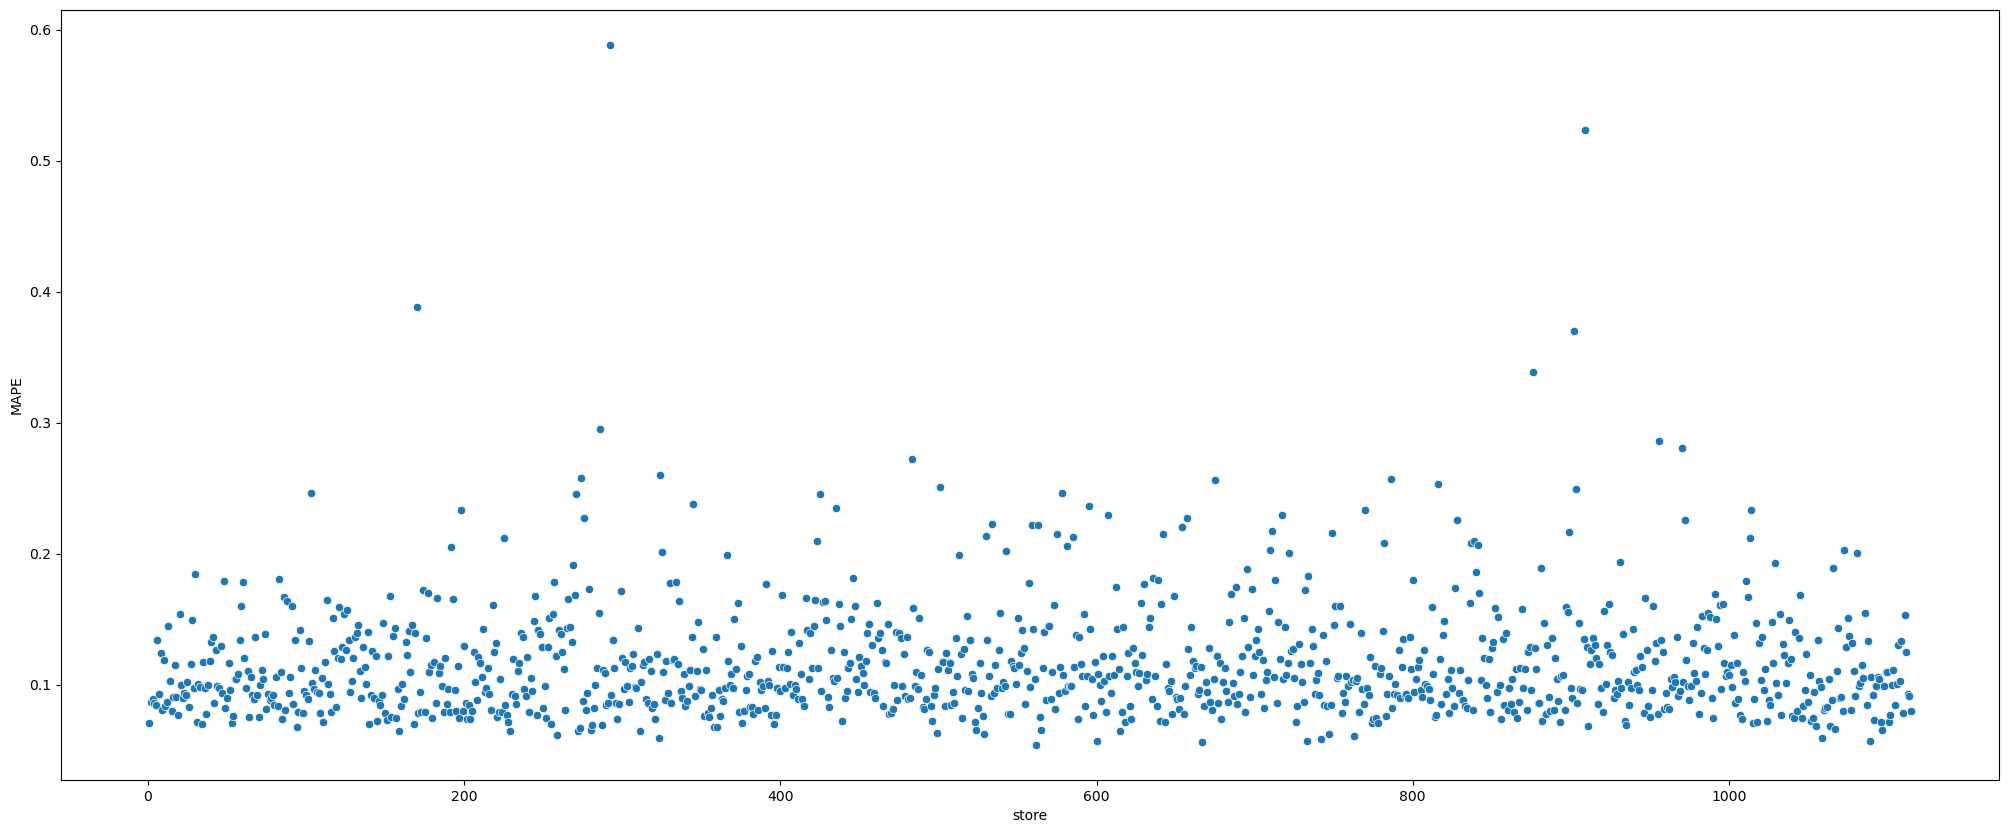

In [ ]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2 Total Performance

In [ ]:
# Sum of worst and best case scenario for all stores

df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'} )
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$285,817,920.00"
1,worst_scenario,"R$284,955,855.73"
2,best_scenario,"R$286,679,971.81"


## 9.3 Machine Learning Performance

C:\Users\andre\AppData\Local\Temp\ipykernel_16412\3761082059.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
C:\Users\andre\AppData\Local\Temp\ipykernel_16412\3761082059.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']
C:\Users\andre\AppData\Local\Temp\ipykernel_16412\3761082059.py:32: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code 

<AxesSubplot: xlabel='predictions', ylabel='error'>

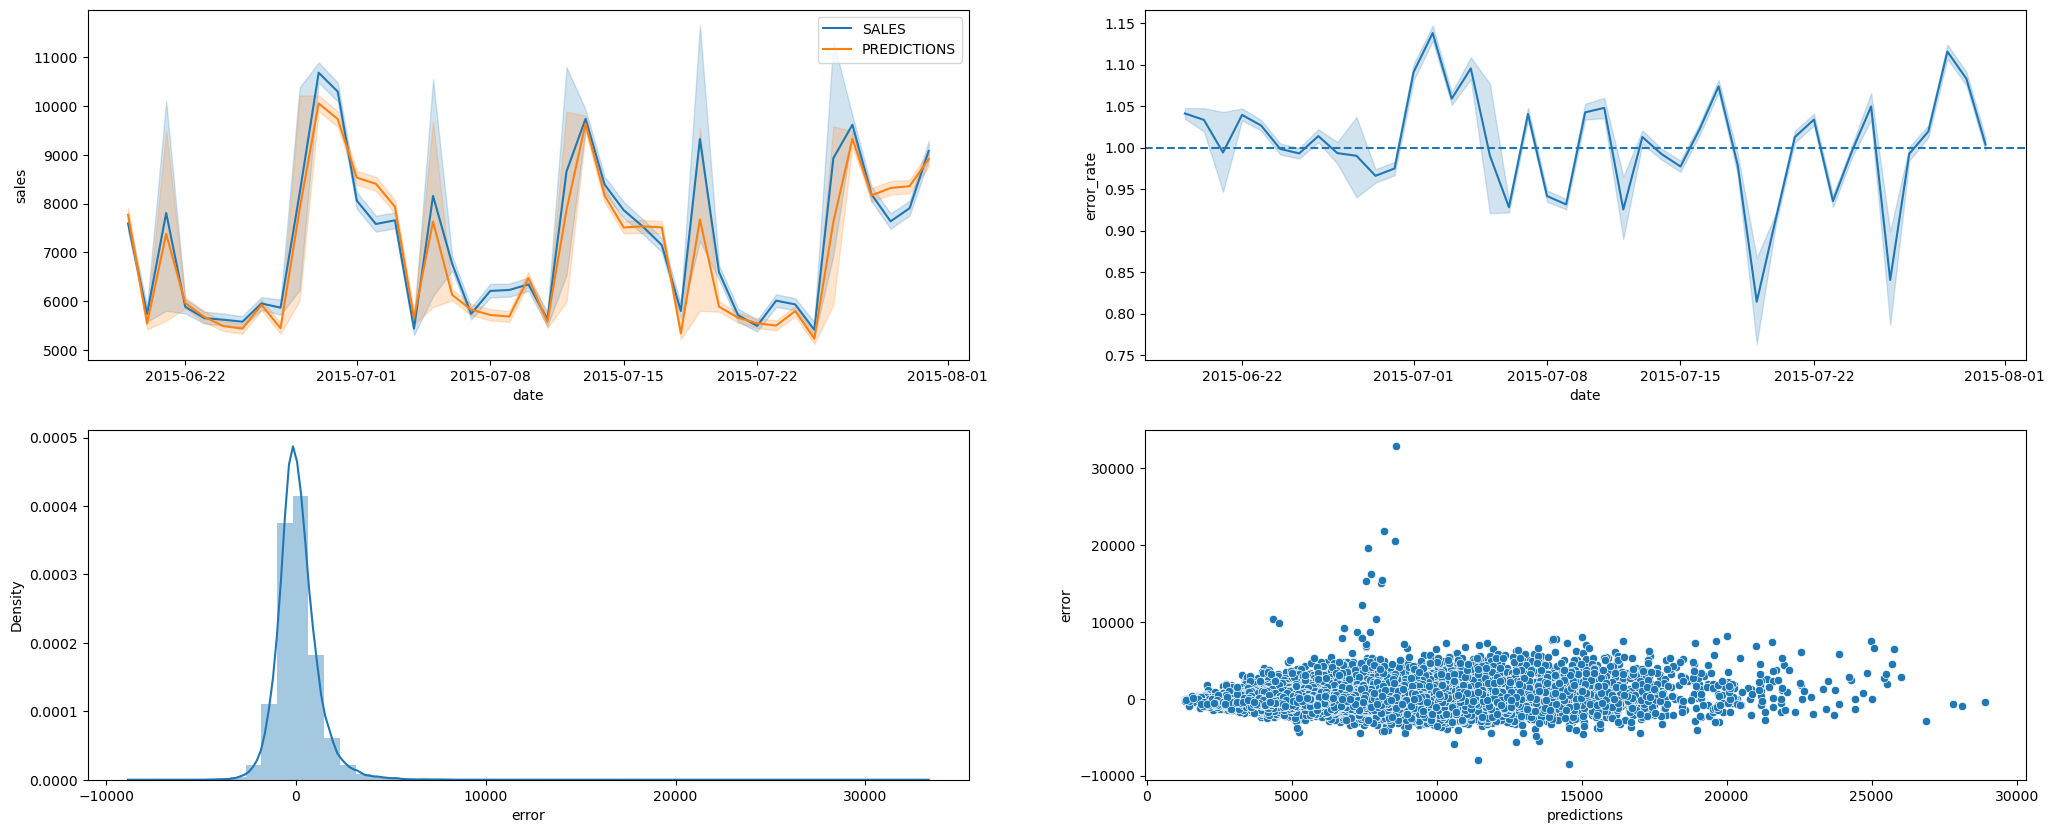

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

# The following charts are a way to monitor sales and predictions over time

plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(x=df9['predictions'], y=df9['error'], data=df9)

# The first graph shows the predictions (y axis) over the six weeks of the test (x axis), showing the proximity between the prediction and 
# sales over time.

# In the second graph, the dashed line represents the error rate equal to 1, which would be ideal for a perfect prediction. However, variations,
# peaks and valleys can be observed, indicating overestimation when above the dashed line and underestimation when below.

# In the third graph, the distribution of the error generated by the model is represented in a curve close to Gaussian/normal.

# In the fourth graph, the residuals graph represents the differences between predictions and sales, showing greater errors when forecasts are 
# between 8k and 10k. The points must be inside a "tube", indicating that the errors are within the expected range, which happens in the case 
# of our plot.

# 10.0 Deploy Model to Production - (Step 10)

## 10.1 Rossmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossmann(object):
    def __init__(self):
        self.home_path='C:/Users/andre/repos/cursos_ds/5_ds_em_producao/'
        self.competition_distance_scaler = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
                                             
    def data_cleaning( self, df1 ):
        ## 1.1. Rename Columns (removed sales and customers)
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
                    'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
        
        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))
        
        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        cols_to_convert_int = ['competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 'promo2_since_year']
        df1[cols_to_convert_int] = df1[cols_to_convert_int].astype(int)

        ## 1.5. Fillout NA
        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        
        df1['promo_interval'].fillna(0, inplace=True )
        df1['month_map'] = df1['date'].dt.month.map( month_map )
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

        return df1


    def feature_engineering( self, df2):
        # year
        df2['year'] = df2['date'].dt.year
        
        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0 FILTERING VARIABLES
        ## 3.1. Line Filtering
        df2 = df2[df2['open'] != 0]

        ## 3.2. Column Selection
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )

        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values )

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values )

        # year
        df5['year'] = self.year_scaler.transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'],columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x * ( 2. * np.pi/52 ) ) )

        cols_selected = [ 'store', 'promo', 'store_type', 'assortment','competition_distance', 'competition_open_since_month',
                          'competition_open_since_year', 'promo2', 'promo2_since_week','promo2_since_year', 'competition_time_month', 
                          'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos','day_sin', 'day_cos', 'week_of_year_sin',
                          'week_of_year_cos']

        return df5[ cols_selected ]
    

    def get_prediction( self, model, original_data, test_data ):

        # prediction
        pred = model.predict( test_data )

        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)

        return original_data.to_json(orient='records', date_format='iso')

## 10.2 API Handler 

In [ ]:
import pickle
import os
import pandas as pd
from flask import Flask, request, Response
from api.rossmann.Rossmann import Rossmann

# Loading model
model = pickle.load( open( '/Users/andre/repos/cursos_ds/5_ds_em_producao/model/model_rossmann.pkl', 'rb') )

# Initialize API
app = Flask( __name__ )
@app.route( '/rossmann/predict', methods=['POST'] )

def rossmann_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )

        # Instantiate Rossmann class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )

        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # data preparation
        df3 = pipeline.data_preparation( df2 )

        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )

        return df_response

    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

## 10.3. API Tester

In [ ]:
# Loading test dataset
df10 = pd.read_csv('/Users/andre/repos/cursos_ds/5_ds_em_producao/datasets/test.csv')

In [ ]:
# Merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# Choose store for prediction
df_test = df_test[df_test['Store'] == 22]
# df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

# Remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [ ]:
# Convert Dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [ ]:
# API Call

# url = 'http://127.0.0.1:5000/rossmann/predict' #127.0.0.1
url = 'https://api-rossmann-predict.onrender.com/api-rossmann-predict' 

header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)

print('Status Code {}'.format(r.status_code))

Status Code 200


In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [ ]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):

    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))

Store Number 22 will sell R$188,002.36 in the next 6 weeks
